# Prepare

## Import

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm.notebook import tqdm

import time
from copy import deepcopy
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
sys.path.append('C:\\_Lib\\python\\rfsoc\\rfsoc_multimode\\example_expts')
sys.path.append('C:\\_Lib\\python\\multimode')
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, get_current_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Warning serial library import failed.
Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver


In [2]:
import json
import os
# path = os.getcwd()
path = r'H:\Shared drives\SLab\Multimode\experiment\250812_qsim' # for data #also update data path in hardware_config_202505.yml
print("path: ", path)

path:  H:\Shared drives\SLab\Multimode\experiment\250812_qsim


## Setup experiment hardware

In [3]:
expt_path = os.path.join(path, 'data')
print('Data will be stored in', expt_path)

Data will be stored in H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data


In [4]:
#Hardware config
curr_path = os.getcwd()
config_file = os.path.join(curr_path, 'configs', 'hardware_config_202505.yml')
config_path = config_file
print('Hardware configs will be read from', config_path)

#Expt config
exp_param_file = os.path.join(curr_path, 'configs', 'experiment_config.yml')
exp_param_path = exp_param_file
print('Experiment params will be read from', exp_param_path)

Hardware configs will be read from c:\_Lib\python\multimode_expts\configs\hardware_config_202505.yml
Experiment params will be read from c:\_Lib\python\multimode_expts\configs\experiment_config.yml


In [5]:
#Set qubit (adopted from QRAM)
qubit_i = 0
import yaml
print(yaml)
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)
print('yaml_cfg: \n', yaml_cfg)

<module 'yaml' from 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\yaml\\__init__.py'>
yaml_cfg: 
 {'device': {'qubit': {'T1': [433.0775501808963], 'f_ge': [3569.7028312412162], 'f_ef': [3426.624285537752], 'ramp_sigma': [0.005], 'ramp_sigma_num': [3.0], 'pulses': {'pi_ge': {'gain': [3522], 'sigma': [0.035], 'length': [0.0], 'type': ['gauss']}, 'hpi_ge': {'gain': [1740], 'length': [0.0], 'sigma': [0.035], 'type': ['gauss']}, 'pi_ef': {'gain': [2931], 'length': [0.0], 'sigma': [0.035], 'type': ['gauss']}, 'hpi_ef': {'gain': [1470], 'sigma': [0.035], 'type': ['gauss']}, 'slow_pi_ge': {'gain': [15], 'sigma': [0.1], 'length': [10], 'type': ['flat_top']}}, 'T1_ef': [127.19717490775781]}, 'readout': {'trig_offset': [450], 'frequency': [749.1893739821222], 'gain': [800], 'phase': [-256.74957872415234], 'threshold': [-48.909669965605076], 'threshold_list': [[-48.909669965605076]], 'man1_drive_list': [0.0], 'man2_drive_list': [0.0], 'readout_length': [1.5], 'relax_delay': [2500], 'c

In [6]:
im = InstrumentManager(ns_address='192.168.137.25') # SLAC lab
im.keys()

dict_keys(['Pyro.NameServer', 'Qick101'])

In [7]:
print(im['Qick101'])

<Pyro4.core.Proxy at 0x19c7c1e9fa0; not connected; for PYRO:obj_590bd7a9236c437e94e83ebbfc72e107@192.168.137.101:35751>


In [8]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)

QICK running on ZCU216, software version 0.2.291

Firmware configuration (built Tue Oct 15 12:06:51 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 32768 samples (4.762 us)
		fs=6881.280 MHz, fabric=430.080 MH

In [9]:
# soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
# print(soc)

In [10]:
# from qick.pyro import make_proxy
# soc, soccfg = make_proxy(ns_host='192.168.137.25', ns_port=9090, proxy_name='Qick101')
# print(soccfg)

In [11]:
# from qick.pyro import make_proxy
# soc, soccfg = make_proxy(ns_host=“171.64.84.155”, ns_port=9090, proxy_name=“QickESR”)
# print(soccfg)

## Choose experiment name

In [12]:
# Path to add
expts_path = 'C:\\_Lib\\python\\multimode_expts'

# Add the path to the system path at the highest priority
sys.path.insert(0, expts_path)
print('Path added at highest priority')

# Verify the path is added
print(sys.path)

# Import the experiments module from multimode
import experiments as meas

# Verify the module is imported from the correct path
print(meas.__file__)

Path added at highest priority
['C:\\_Lib\\python\\multimode_expts', 'C:\\_Lib\\python', 'C:\\_Lib\\python\\slab', 'C:\\_Lib\\python\\qick\\qick_lib', 'C:\\_Lib\\python\\rfsoc\\rfsoc_multimode\\example_expts', 'c:\\_Lib\\python\\multimode_expts', 'c:\\Users\\26049\\.conda\\envs\\slab\\python38.zip', 'c:\\Users\\26049\\.conda\\envs\\slab\\DLLs', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib', 'c:\\Users\\26049\\.conda\\envs\\slab', '', 'C:\\Users\\26049\\AppData\\Roaming\\Python\\Python38\\site-packages', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\easy_lmfit-1.0-py3.8.egg', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\attrdict-2.0.1-py3.8.egg', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\win32', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\win32\\lib', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\Pythonwin', '/home/xilinx/jupyter_notebooks/', 'C:\\_Lib\\pytho

### Previous experiment data

In [13]:
"""Reopen saved data"""
def prev_data(expt_path, filename=None, prefix=None):
    if prefix is not None:
        temp_data_file = os.path.join(expt_path,get_current_filename(expt_path, prefix=prefix, suffix='.h5'))
        
    else:
        temp_data_file = expt_path+'\\'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        # print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs, temp_data_file

Handling of parameter updating: 

The experiment objects are initialized with the `config_path`, meaning they will read from our hardware config file and set the `self.cfg` to that. 
But here we will be overriding that immediately with a new config AttrDict that is at first just a deepcopy of that yaml file but as we go over each cell the values inside this `config_thisrun` will be gradually updated. 
Throughout the notebook, the updated config will only live in memory, until you decide to write it to disk.


What experiments to run?
 
Depending on stage of cooldown, we will run a different sequence of calibration experiments. For example, amplitude rabi don't need to be updated every time, but the frequency correction from T2 is important to do every day. In the dictionary experiments to run, we will speciy the experiments we want to run. 

## Datset for Sidebands

In [14]:
from dataset import *
from dataset import storage_man_swap_dataset
import os 

file_path = os.path.join(expts_path, 'man1_storage_swap_dataset.csv')
# print(os.makedirs(file_path, exist_ok=True))
ds = storage_man_swap_dataset(file_path)

ds_thisrun = storage_man_swap_dataset(ds.create_copy())
ds_thisrun_file_path = os.path.join(expts_path, ds_thisrun.filename)
ds_thisrun.df

Creating a copy of the dataset at path: man1_storage_swap_dataset_copy.csv


,stor_name,freq (MHz),precision (MHz),pi (mus),h_pi (mus),gain (DAC units),last_update
0,M1-S1,348.705722,NaN,1.209192,0.604596,2977,2025-08-18 17:09:22.472298
1,M1-S2,520.119712,NaN,1.157138,0.578569,4765,2025-08-18 17:09:22.478282
2,M1-S3,695.791320,NaN,1.057229,0.528615,4883,2025-08-18 17:09:22.486261
3,M1-S4,873.467193,NaN,1.002202,0.501101,9080,2025-08-18 17:17:21.751136
4,M1-S5,1052.583825,NaN,1.838050,0.919025,7115,2025-08-18 17:09:22.493242
5,M1-S6,1244.545889,NaN,1.359600,0.679800,13375,2025-08-18 17:09:22.500224
6,M1-S7,1422.176794,NaN,2.416182,1.208091,9522,2025-08-18 17:09:22.507236
7,M1-S8,-1.000000,-1.00,-1.000000,-1.000000,-1,51:31.3
8,M1-S9,-1.000000,-1.00,-1.000000,-1.000000,-1,51:31.3
9,M1-S10,-1.000000,-1.00,-1.000000,-1.000000,-1,51:31.3


In [15]:
config_thisrun = AttrDict(deepcopy(yaml_cfg))


In [16]:
config_thisrun.device.storage.storage_man_file = ds_thisrun_file_path
config_thisrun.device.manipulate

{'f_ge': [4984.8599830542125, 5157.8527963217475],
 'displace_sigma': [0.05, 0.05],
 'revival_time': [1.6562926457024991, 1.7366205852286094],
 'revival_stark_shift': [-1.092140493733816, -2.6792227141937364],
 'gain_to_alpha': [0.0007377158577217475, 0.00020045],
 'freq_to_alpha': [0.495062203431879, 0.0],
 'chi_ge': [-0.310456],
 'chi_ef': [-0.24480332166390534],
 'ramp_sigma': 0.005}

## Experiments to run

In [17]:
expts_to_run = {# readout 
                'res_spec': True, # Readout spectroscopy
                'single_shot': True, 
                # qubit ge 
                'pulse_probe_ge': True,
                't2_ge': True, 
                'amplitude_ge': True,
                't1_ge': True,
                # qubit ef
                'pulse_probe_ef': True,
                't2_ef': True,
                'amplitude_ef': True,
                't1_ef': True,

                # manipulate 
                'man_modes': [1], # [1,2] if also want to run mode 2
                'pulse_probe_f0g1': True,
                'length_rabi_sweep':True,
                'length_rabi':False, # this will run automatically if the length_rabi_sweep is set to True
                'chi_ge': True, 
                'chi_ef': True,
                'RB': False,

                #storage
                'stor_modes': [1,2,3,4,5,6,7], # [1,2, .., 7] if also want to run  all modes 
                # 'stor_modes': [3, 4, 5], # [1,2, .., 7] if also want to run  all modes 
                'stor_spectroscopy': True,
                'sideband_freq_sweep': True,
                'sideband_length_rabi': True,
                # 'storage_t1': True
                }

In [18]:
from datetime import datetime

# create directory inside data folder for autocalibration plots
# Get the current date and add it to the directory name
autocalib_path = os.path.join(expt_path, f'autocalibration_plots_{datetime.now().strftime("%Y-%m-%d")}')

os.makedirs(autocalib_path, exist_ok=True)
print('Directory created for autocalibration plots at:', autocalib_path)

Directory created for autocalibration plots at: H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\autocalibration_plots_2025-09-30


# Qubit characterization

## Resonator 

### Resonator Spectroscopy

Fitting parameters are wrong because of using the hanger function (more or less reflection/2), instead of transmission. Is this an easy fix?

In [20]:
def do_res_spec(config_thisrun): 
    rspec = meas.single_qubit.resonator_spectroscopy.ResonatorSpectroscopyExperiment(
        soccfg=soc, path=expt_path, prefix='ResonatorSpectroscopyExperiment', config_file=config_path
    )

    rspec.cfg = AttrDict(deepcopy(config_thisrun))

    span = 1.5
    expts = 150
    start = config_thisrun.device.readout.frequency[0] - span / 2.5
    
    rspec.cfg.expt = dict(
        start = start, # resonator frequency to be mixed up [MHz]
        step = span / expts, # min step ~1 Hz
        expts = 250, # Number experiments stepping from start
        reps = 500, # Number averages per point
        pulse_e = False, # add ge pi pulse prior to measurement
        pulse_f = False, # add ef pi pulse prior to measurement
        pulse_cavity = False,  # prepulse on cavity prior to measurement (False also disables next line)
        cavity_pulse = [4984.373226159381, 800, 2, 0], # [frequency, gain, length, phase]  const pulse
        qubit = 0,
    )

    rspec.cfg.device.readout.relax_delay = [50] # Wait time between experiments [us]
    rspec.go(analyze=True, display=True, progress=True, save=True)
    return rspec

def update_res_spec(rspec, config_thisrun):
    config_thisrun.device.readout.frequency = [rspec.data['fit'][0]]
    print('Updated readout frequency!')

In [ ]:
if expts_to_run['res_spec']: 
    rspec = do_res_spec(config_thisrun=config_thisrun)

In [ ]:
rspec.data['fit'][0]

In [ ]:
if expts_to_run['res_spec']: 
    update_res_spec(rspec, config_thisrun)
    print('Resonator spectroscopy done!')

## Single Shot

In [19]:
def do_single_shot(
    config_thisrun,
    expt_path,
    config_path,
    qubits=[0],
    reps=5000,
    check_f=False,
    active_reset=True,
    man_reset=False,
    storage_reset=False,
    qubit=0,
    pulse_manipulate=False,
    cavity_freq=4984.373226159381,
    cavity_gain=400,
    cavity_length=2,
    prepulse=False,
    pre_sweep_pulse=None,
    gate_based=True,
    relax_delay=500
):
    """Run the single shot experiment with configurable parameters."""

    # if pre_sweep_pulse is None:
    #     pre_sweep_pulse = [
    #         ['qubit', 'ge', 'pi', 0],
    #     ]

    hstgrm = meas.single_qubit.single_shot.HistogramExperiment(
        soccfg=soc, path=expt_path, prefix='HistogramExperiment', config_file=config_path
    )

    hstgrm.cfg = AttrDict(deepcopy(config_thisrun))

    hstgrm.cfg.expt = {
        'qubits': qubits,
        'reps': reps,
        'check_f': check_f,
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'qubit': qubit,
        'pulse_manipulate': pulse_manipulate,
        'cavity_freq': cavity_freq,
        'cavity_gain': cavity_gain,
        'cavity_length': cavity_length,
        'prepulse': prepulse,
        'pre_sweep_pulse': pre_sweep_pulse,
        'gate_based': gate_based,
    }

    hstgrm.cfg.device.readout.relax_delay = [relax_delay]  # Wait time between experiments [us]
    hstgrm.go(analyze=False, display=False, progress=True, save=True)
    from multimode_expts.fit_display_classes import Histogram
    
    hist_analysis = Histogram(
            hstgrm.data, verbose=True,
             span=None, threshold=None, config=hstgrm.cfg,
        )
    return hstgrm, hist_analysis


def update_single_shot(hist_analysis, config_thisrun):
    """Update the configuration based on single shot experiment results."""
    
    hist_analysis.analyze(plot = True)
    fids = hist_analysis.results['fids']
    confusion_matrix = hist_analysis.results['confusion_matrix']
    thresholds_new = hist_analysis.results['thresholds']
    angle = hist_analysis.results['angle']
    print(fids)

    config_thisrun.device.readout.phase = [config_thisrun.device.readout.phase[0] + angle]
    config_thisrun.device.readout.threshold = thresholds_new
    config_thisrun.device.readout.threshold_list = [thresholds_new]
    config_thisrun.device.readout.Ie = [np.median(hist_analysis.data['Ie_rot'])]
    config_thisrun.device.readout.Ig = [np.median(hist_analysis.data['Ig_rot'])]
    if hist_analysis.cfg.expt.active_reset:
        config_thisrun.device.readout.confusion_matrix_with_active_reset = confusion_matrix
    else:
        config_thisrun.device.readout.confusion_matrix_without_reset = confusion_matrix
    print('Updated readout!')

In [20]:
hstgrm = None
if expts_to_run['single_shot']: 
    hstgrm = do_single_shot(config_thisrun,  expt_path, config_path, reps = 5000, active_reset=True, relax_delay = 5)


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00049_HistogramExperiment.h5
{'device': {'qubit': {'T1': [433.0775501808963], 'f_ge': [3569.7028312412162], 'f_ef': [3426.624285537752], 'ramp_sigma': [0.005], 'ramp_sigma_num': [3.0], 'pulses': {'pi_ge': {'gain': [3522], 'sigma': [0.035], 'length': [0.0], 'type': ['gauss']}, 'hpi_ge': {'gain': [1740], 'length': [0.0], 'sigma': [0.035], 'type': ['gauss']}, 'pi_ef': {'gain': [2931], 'length': [0.0], 'sigma': [0.035], 'type': ['gauss']}, 'hpi_ef': {'gain': [1470], 'sigma': [0.035], 'type': ['gauss']}, 'slow_pi_ge': {'gain': [15], 'sigma': [0.1], 'length': [10], 'type': ['flat_top']}}, 'T1_ef': [127.19717490775781]}, 'readout': {'trig_offset': [450], 'frequency': [749.1893739821222], 'gain': [800], 'phase': [-256.74957872415234], 'threshold': [-48.909669965605076], 'threshold_list': [[-48.909669965605076]], 'man1_drive_list': [0.0], 'man2_drive_list': [0.0], 'readout_length': [1.5], 'relax_delay': [5], 'confusion_matrix_wi

Active reset is enabled
Unrotated:
Ig -105.93073593073593 +/- 32.213185916687436 	 Qg 7.54978354978355 +/- 32.224177472323056 	 Amp g 106.19943524556
Ie 10.41991341991342 +/- 34.77368549081912 	 Qe 9.722943722943723 +/- 32.71744157614855 	 Amp e 14.251674649598993
updating temp data
Rotated:
Ig -105.75792960276246 +/- 32.226531687112704 	 Qg 9.473875361024882 +/- 32.21083072648645 	 Amp g 106.18142016482494
Ie 10.763852676341338 +/- 34.763651148609355 	 Qe 9.624950743732278 +/- 32.72810328633314 	 Amp e 14.439536047160695


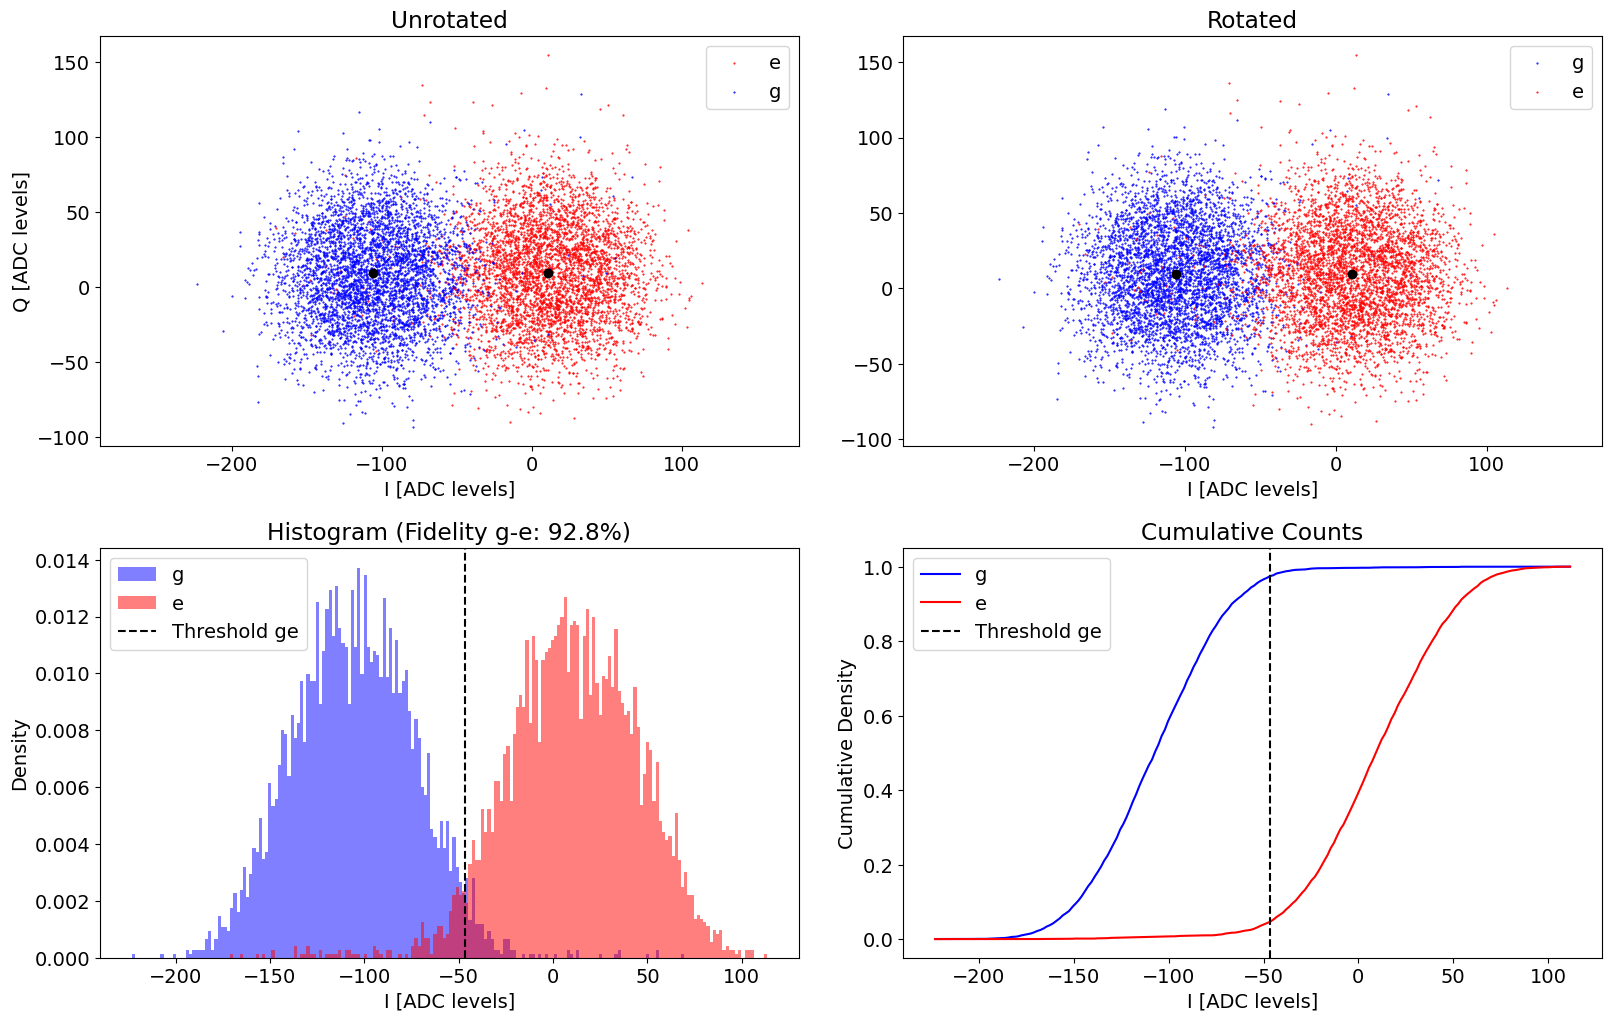

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-09-30_00-19-05_histogram.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-09-30.md


In [21]:
hstgrm[1].analyze(plot = True)

In [34]:
config_thisrun.device.readout

{'trig_offset': [450],
 'frequency': [749.1893739821222],
 'gain': [800],
 'phase': [-125.41540623738997],
 'threshold': [-50.96593150657506],
 'threshold_list': [[-50.96593150657506]],
 'man1_drive_list': [0.0],
 'man2_drive_list': [0.0],
 'readout_length': [1.5],
 'relax_delay': [2500],
 'confusion_matrix_with_reset': [0.9964530022802125,
  0.0035469977197875036,
  0.013768302080657598,
  0.9862316979193424],
 'confusion_matrix_without_reset': [0.9069999999999999,
  0.09300000000000008,
  0.08341668333666732,
  0.9165833166633327],
 'Ie': [5.177867478512083],
 'Ig': [-104.67323195159086],
 'confusion_matrix_with_active_reset': [0.9557350565428109,
  0.04426494345718912,
  0.04819277108433736,
  0.9518072289156626]}

Active reset is enabled
Unrotated:
Ig -105.24891774891775 +/- 32.97256654571871 	 Qg 9.502164502164502 +/- 32.16481586764571 	 Amp g 105.67698811730322
Ie 11.08982683982684 +/- 34.735352865587124 	 Qe 8.541125541125542 +/- 32.720216287933134 	 Amp e 13.997681409669633
updating temp data
Rotated:
Ig -105.37786551851556 +/- 32.96948353243872 	 Qg 8.61455992464478 +/- 32.16797600122914 	 Amp g 105.72939602557865
Ie 11.013003771407295 +/- 34.731985068542535 	 Qe 8.692176597502966 +/- 32.723791128543084 	 Amp e 14.029974557040704

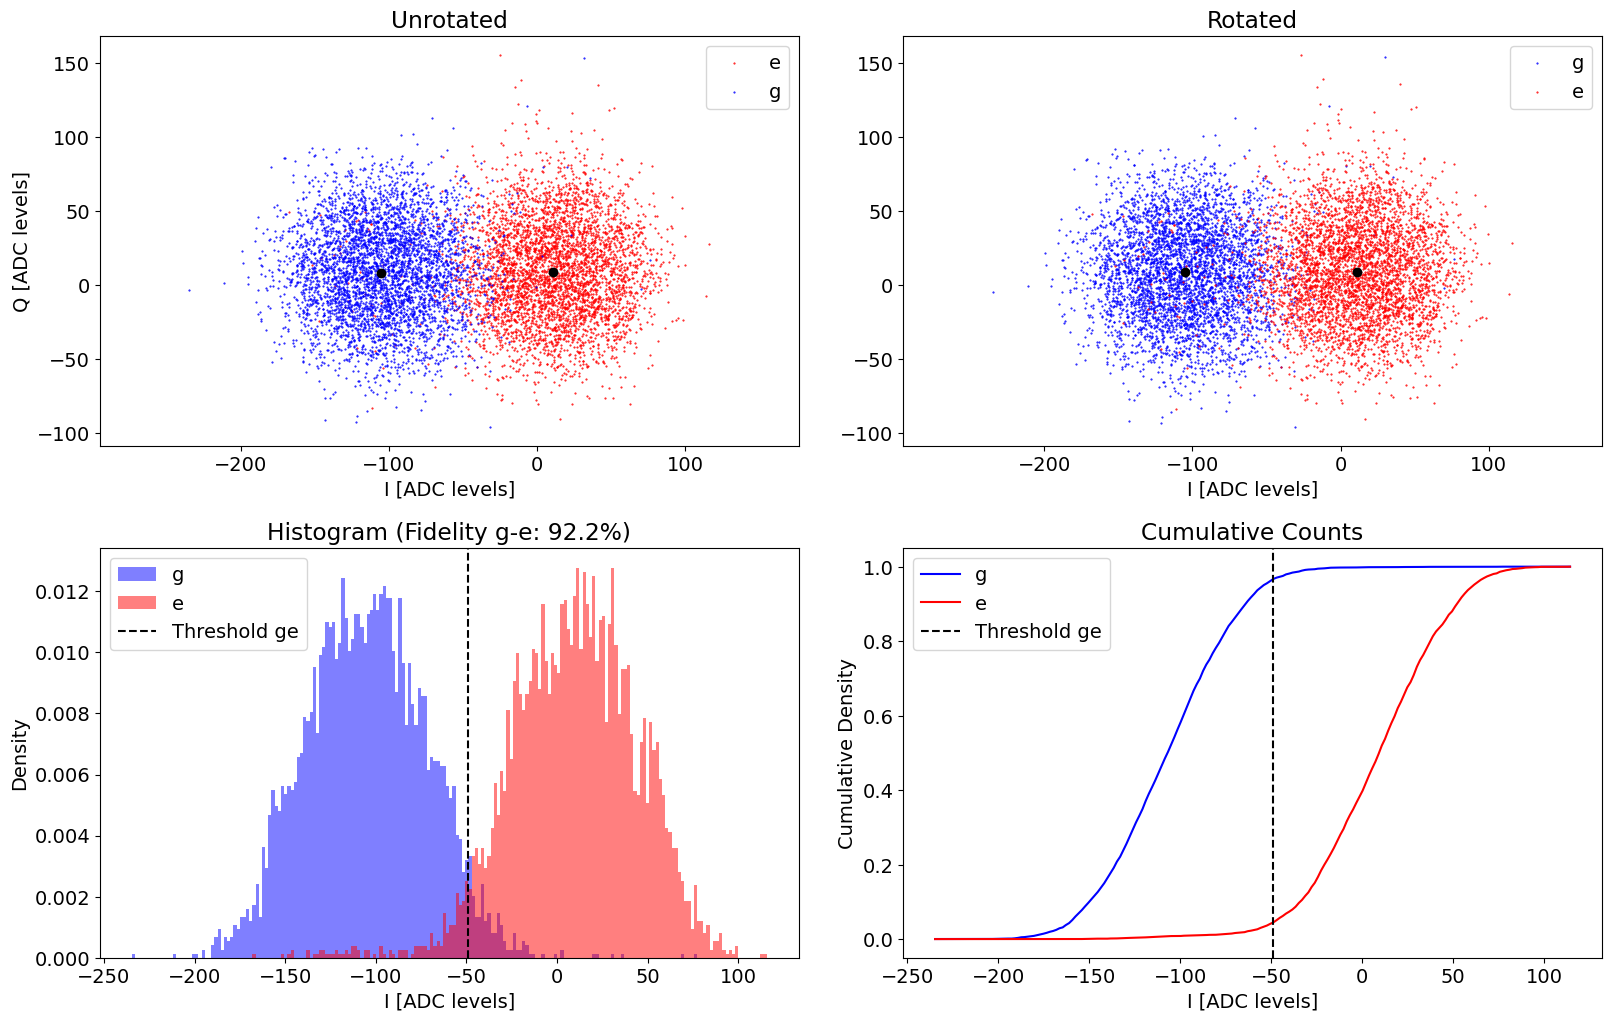

In [ ]:
if expts_to_run['single_shot']:
    update_single_shot(hstgrm[1], config_thisrun)
    print('Single shot done!')

In [24]:
# hstgrm.cfg

### JPA Calibration

In [25]:
def do_jpa_current_sweep( config_thisrun,
    expt_path,
    config_path,
    jpa_current_start=-8,
    jpa_current_step=0.1,
    jpa_current_stop = -2,
    qubits=[0],
    reps=5000,
    check_f=False,
    active_reset=False,
    man_reset=False,
    storage_reset=False,
    qubit=0,
    pulse_manipulate=False,
    cavity_freq=4984.373226159381,
    cavity_gain=800,
    cavity_length=2,
    prepulse=False,
    pre_sweep_pulse=None,
    gate_based=True,
    relax_delay=2500
):
    """Run the single shot experiment with configurable parameters."""
    from multimode_expts.sequential_experiment_classes import histogram_sweep_class
    experiment_class = histogram_sweep_class
    sweep_experiment_name = 'histogram_jpa_current_sweep'
    class_for_exp = experiment_class(soccfg=soc, path=expt_path, prefix=sweep_experiment_name, config_file=config_path, exp_param_file=exp_param_file)

    class_for_exp.yaml_cfg = AttrDict(deepcopy(config_thisrun))
    
    class_for_exp.loaded[sweep_experiment_name] =  {
        'qubits': qubits,
        'reps': reps,
        'check_f': check_f,
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'qubit': qubit,
        'pulse_manipulate': pulse_manipulate,
        'cavity_freq': cavity_freq,
        'cavity_gain': cavity_gain,
        'cavity_length': cavity_length,
        'prepulse': prepulse,
        'pre_sweep_pulse': pre_sweep_pulse,
        'gate_based': gate_based,
        'jpa_current_start': jpa_current_start,
        'jpa_current_step': jpa_current_step,
        'jpa_current_stop': jpa_current_stop,
        'relax_delay': relax_delay
    }

   
    class_for_exp.yaml_cfg.device.readout.relax_delay = [relax_delay]  # Wait time between experiments [us]

    return eval('class_for_exp.run_sweep')( sweep_experiment_name = sweep_experiment_name)

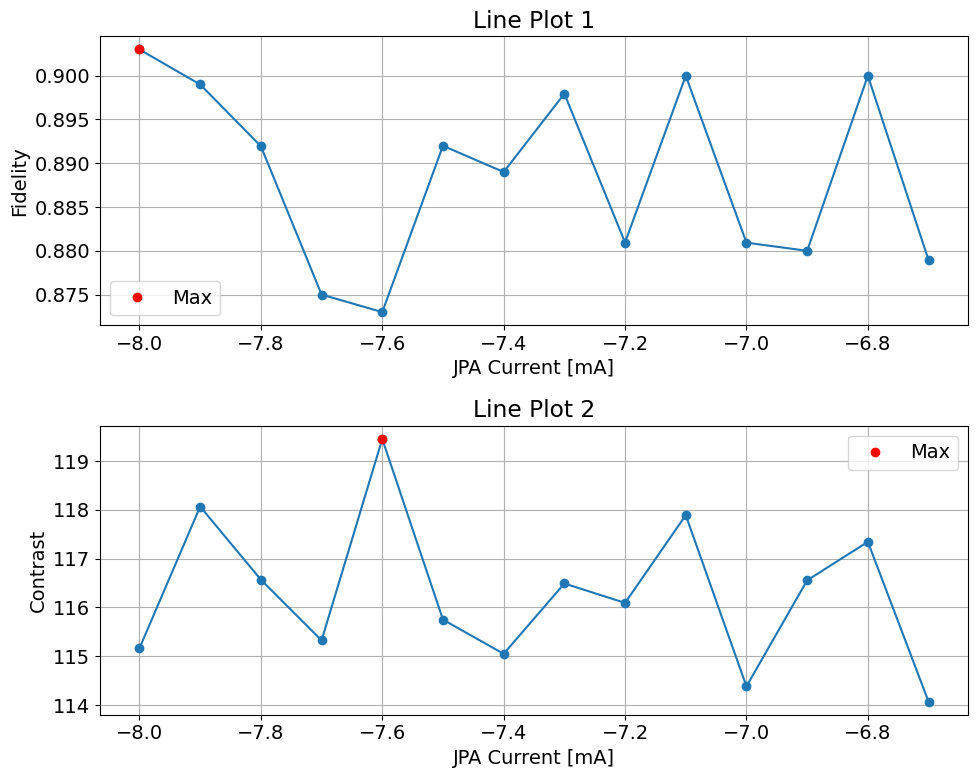

Index: 14 JPA Current = -6.600000000000005 mA


KeyboardInterrupt: 

In [31]:
sweep_func = do_jpa_current_sweep(config_thisrun, expt_path,
                                   config_path, reps=1000,
                                    #  jpa_current_start=0., jpa_current_step=0.2,
                                    #    jpa_current_stop=10., 
                                      #  active_reset=True,
                                         relax_delay=5)

In [ ]:
from slab.instruments import YokogawaGS200
dcflux = YokogawaGS200(address="192.168.137.149")
dcflux.set_output(True)
dcflux.set_mode('current')

jpa_current = -1.875 # mA
jpa_current = 0 # mA
current = jpa_current * 1e-3  # Convert from mA to A
dcflux.set_current(current)

print(1e3 * dcflux.get_current(), 'mA')

#### Sweep both gain and current

In [ ]:
def do_jpa_current_gain_sweep( config_thisrun,
    expt_path,
    config_path,
    jpa_current_start=3.7,
    jpa_current_step=0.005,
    jpa_current_stop = 3.8,
    jpa_gain_start=-15,
    jpa_gain_step=0.5,
    jpa_gain_stop = -11,
    qubits=[0],
    reps=1000,
    check_f=False,
    active_reset=False,
    man_reset=False,
    storage_reset=False,
    qubit=0,
    pulse_manipulate=False,
    cavity_freq=4984.373226159381,
    cavity_gain=800,
    cavity_length=2,
    prepulse=False,
    pre_sweep_pulse=None,
    gate_based=True,
    relax_delay=2500
):
    """Run the single shot experiment with configurable parameters."""
    from multimode_expts.sequential_experiment_classes import histogram_sweep_class
    experiment_class = histogram_sweep_class
    sweep_experiment_name = 'histogram_jpa_gain_current_sweep'
    class_for_exp = experiment_class(soccfg=soc, path=expt_path, prefix=sweep_experiment_name, config_file=config_path, exp_param_file=exp_param_file)

    class_for_exp.yaml_cfg = AttrDict(deepcopy(config_thisrun))
    
    class_for_exp.loaded[sweep_experiment_name] =  {
        'qubits': qubits,
        'reps': reps,
        'check_f': check_f,
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'qubit': qubit,
        'pulse_manipulate': pulse_manipulate,
        'cavity_freq': cavity_freq,
        'cavity_gain': cavity_gain,
        'cavity_length': cavity_length,
        'prepulse': prepulse,
        'pre_sweep_pulse': pre_sweep_pulse,
        'gate_based': gate_based,
        'jpa_current_start': jpa_current_start,
        'jpa_current_step': jpa_current_step,
        'jpa_current_stop': jpa_current_stop,
        'jpa_gain_start': jpa_gain_start,
        'jpa_gain_step': jpa_gain_step,
        'jpa_gain_stop': jpa_gain_stop,
    }

    print('relax delay set to:', relax_delay)
    class_for_exp.yaml_cfg.device.readout.relax_delay = [relax_delay]  # Wait time between experiments [us]

    return eval('class_for_exp.run_sweep')( sweep_experiment_name = sweep_experiment_name)

In [ ]:
sweep_func = do_jpa_current_gain_sweep(config_thisrun, expt_path,
                                        config_path, reps=1000, 
                                        jpa_current_start=0,
                                        jpa_current_step=0.05,
                                        jpa_current_stop=5,
                                        jpa_gain_start=-15,
                                        jpa_gain_step=0.5,
                                        jpa_gain_stop=-11,
                                        # active_reset=True, relax_delay=5
                                        )

## Qubit ge

### Pulse-probe

In [23]:
def do_pulse_probe(
    config_thisrun, 
    start=3560,  # [MHz]
    step=0.1,  # min step ~1 MHz
    expts=200,  # Number of experiments stepping from start
    reps=2000,  # Number of averages per point
    rounds=1,  # Number of start to finish sweeps to average over
    length=1,  # Qubit probe constant pulse length [us]
    gain=100,  # Qubit pulse gain
    sigma=0.1,  # Qubit flat top sigma
    qubit=0,
    prepulse=False,
    pre_sweep_pulse=[],
    gate_based=False,
    relax_delay=250,  # Wait time between experiments [us]
    ): 
    qspec = meas.single_qubit.pulse_probe_spectroscopy.PulseProbeSpectroscopyExperiment(
        soccfg=soc, path=expt_path, prefix='PulseProbeSpectroscopyExperiment', 
        config_file=config_file
    )

    qspec.cfg = AttrDict(deepcopy(config_thisrun))

    qspec.cfg.expt = dict(
        qubits = [0],
        start=start,
        step=step,
        expts=expts,
        reps=reps,
        rounds=rounds,
        length=length,
        gain=gain,
        sigma=sigma,
        qubit=qubit,
        prepulse = prepulse, 
        pre_sweep_pulse = pre_sweep_pulse,
        gate_based = gate_based,
    )

    qspec.cfg.device.readout.relax_delay = [relax_delay] # Wait time between experiments [us]
    qspec.go(analyze=True, display=True, progress=True, save=True)
    return qspec

def update_pulse_probe_ge(qspec, config_thisrun):
    config_thisrun.device.qubit.f_ge = [qspec.data['fit_avgi'][2]]
    print('Updated qubit frequency!')

pulssing on channel:  2
qubit register page: 1, frequency register: 22


  0%|          | 0/50000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00005_PulseProbeSpectroscopyExperiment.h5
Found peak in amps at [MHz] 3569.70447394146, HWHM -0.35091947494395576
Found peak in I at [MHz] 3569.704199898024, HWHM 0.35002794033873685
Found peak in Q at [MHz] 3569.6800249677854, HWHM 0.32974988939076016


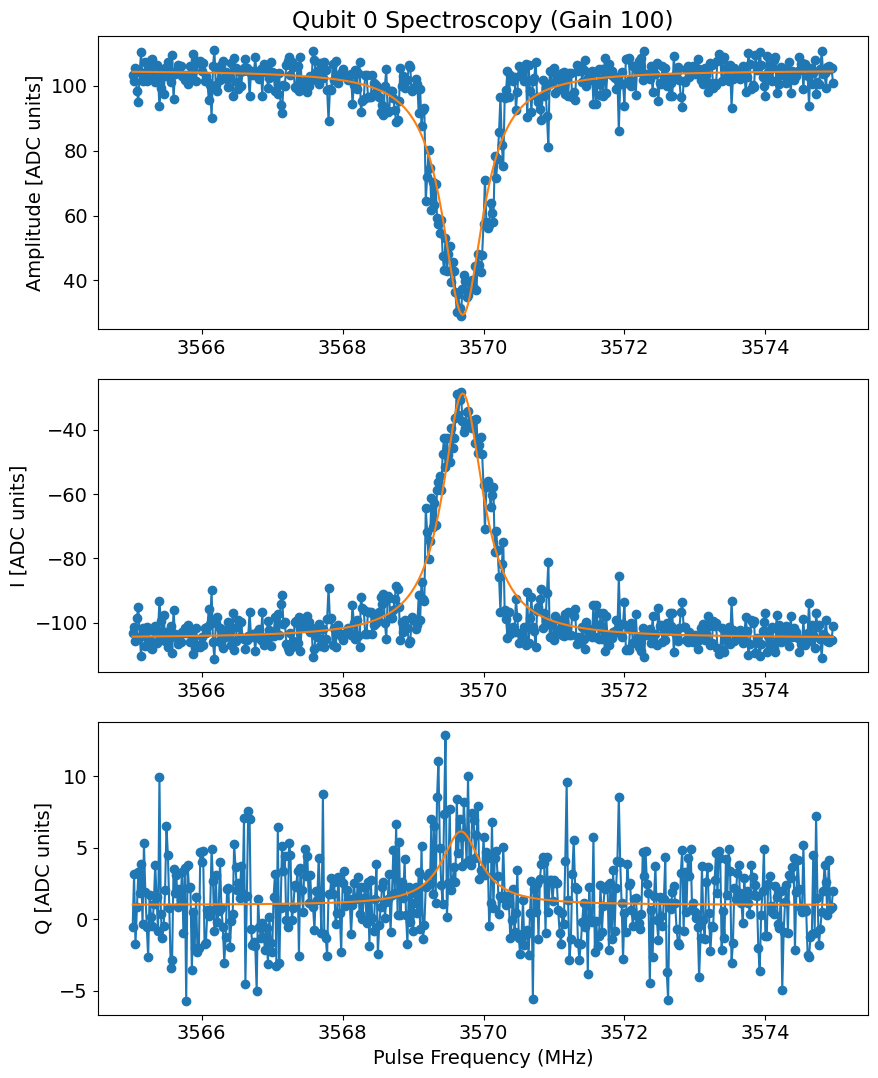

In [24]:
qspec =  do_pulse_probe(
    config_thisrun=config_thisrun,
    start=3565,  # [MHz]
    step=0.02,  # min step ~1 MHz
    expts=500,  # Number of experiments stepping from start
    reps=100,  # Number of averages per point
    rounds=1,  # Number of start to finish sweeps to average over
    # rounds=1000000,  # Number of start to finish sweeps to average over
    length=1,  # Qubit probe constant pulse length [us]
    gain=100,  # Qubit pulse gain
    # gain=30000,  # Qubit pulse gain
    sigma=0.1,  # Qubit flat top sigma
    qubit=0,
    prepulse=False,
    pre_sweep_pulse=[],
    gate_based=False,
    relax_delay=300  # Wait time between experiments [us]
    # relax_delay=3  # Wait time between experiments [us]
)

In [ ]:
# if expts_to_run['pulse_probe_ge']: 
#     qspec = do_pulse_probe_ge(config_thisrun)

In [ ]:
if expts_to_run['pulse_probe_ge']:
    update_pulse_probe_ge(qspec, config_thisrun)
    print('Pulse probe spectroscopy done!')

### T2 Ramsey

In [45]:
def do_t2_ramsey_ge(
    config_thisrun,
    expt_path,
    config_path,
    pre_sweep_pulse=None,
    post_sweep_pulse=None,
    step_size=soc.cycles2us(8),
    if_ef=False,
    ef_init=True, # redundant
    start=0.01,
    expts=201,
    ramsey_freq=3,  # [MHz]
    reps=200,
    rounds=1,
    qubits=[0],
    user_defined_freq=[False, 3568.2038290468167, 5304, 0.035],
    f0g1_cavity=0,
    normalize=False,
    active_reset=True,
    man_reset=True,
    storage_reset=False,
    prepulse=None,
    postpulse=None,
    pre_active_reset_pulse=False,
    gate_based=False,
    advance_phase=0,
    echoes=[False, 0],
    relax_delay=200
):
    """Run the T2 Ramsey experiment with all config params as function arguments."""
    t2ramsey = meas.single_qubit.t2_ramsey.RamseyExperiment(
        soccfg=soc, path=expt_path, prefix='RamseyExperiment', config_file=config_path
    )

    t2ramsey.cfg = AttrDict(deepcopy(config_thisrun))
    checkEF = False
    qubit_ge_init = False
    qubit_ge_after = False
    if if_ef:
        checkEF = True
        qubit_ge_init = True if ef_init else False
        qubit_ge_after = True if ef_init else False

    t2ramsey.cfg.expt = {
        'start': start,
        'step': step_size,
        'expts': expts,
        'ramsey_freq': ramsey_freq,
        'reps': reps,
        'rounds': rounds,
        'qubits': qubits,
        'checkEF': checkEF,
        'user_defined_freq': user_defined_freq,
        'qubit_ge_init': qubit_ge_init,
        'qubit_ge_after': qubit_ge_after,
        'f0g1_cavity': f0g1_cavity,
        'normalize': normalize,
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'prepulse': False if pre_sweep_pulse is None else True if prepulse is None else prepulse,
        'postpulse': False if post_sweep_pulse is None else True if postpulse is None else postpulse,
        'pre_active_reset_pulse': pre_active_reset_pulse,
        'pre_sweep_pulse': pre_sweep_pulse,
        'post_sweep_pulse': post_sweep_pulse,
        'gate_based': gate_based,
        'advance_phase': advance_phase,
        'echoes': echoes
    }

    t2ramsey.cfg.device.readout.relax_delay = [relax_delay]  # Wait time between experiments [us]
    # t2ramsey.cfg.device.qubit.f_ge = [3567.346809921427]
    t2ramsey.go(analyze=False, display=False, progress=True, save=True)
    from multimode_expts.fit_display_classes import RamseyFitting
    t2ramsey_analysis = RamseyFitting(
        t2ramsey.data, config=t2ramsey.cfg,
    )
    return t2ramsey_analysis



def update_t2_ramsey_ge(t2ramsey, config_thisrun):
    """Update the configuration based on T2 Ramsey experiment results."""
    config_thisrun.device.qubit.f_ge = [config_thisrun.device.qubit.f_ge[0] + min(t2ramsey.data['f_adjust_ramsey_avgi'])]
    print('Updated qubit ge frequency to:', config_thisrun.device.qubit.f_ge[0])



In [ ]:
t2ramsey_ge = None
if expts_to_run['t2_ge']:
    # pre_sweep_pulse = [
    #     ['qubit', 'ge', 'pi', 0],
    #     ['qubit', 'ef', 'pi', 0],
    #     ['man', 'M1', 'pi', 0],
    # ]
    pre_sweep_pulse = None
    t2ramsey_ge = do_t2_ramsey_ge(config_thisrun, expt_path, config_path,
                                  ramsey_freq=0.1,
                                  step_size=1,
                                  expts=100,
                                  pre_sweep_pulse=pre_sweep_pulse,
                                  reps=100, active_reset=False, relax_delay=2500)
    t2ramsey_ge.analyze()
    t2ramsey_ge.display(title_str='T2_ge')
    print('T2 Ramsey done!')

fge is  3569.6978631006828
fef is  3426.624285537752

  0%|          | 0/10000 [00:00<?, ?it/s]

In [34]:
# config_thisrun.device.qubit.f_ge[0]= 3571.672429380876

In [47]:
if expts_to_run['t2_ge']:
    update_t2_ramsey_ge(t2ramsey_ge, config_thisrun)
    print('T2 Ramsey updated!')

Updated qubit ge frequency to: 3569.7028312412162
T2 Ramsey updated!

In [ ]:
# idata = t2ramsey_ge.data['idata']
# idata = idata.reshape((len(idata)//4,4))

# qdata = t2ramsey_ge.data['qdata']
# qdata = qdata.reshape((len(qdata)//4,4))

# fig, axs = plt.subplots(nrows=4,ncols=2, figsize=(8,8))
# for kk in range(4):
#     axs[kk,0].hist(idata[:,kk], bins=100)
#     axs[kk,1].hist(qdata[:,kk], bins=100)
# None

No echoes in the data
length 100 100
Attempted to init fitparam 4 to -44.0510906926407, which is out of bounds -1.744220779220779 to 26.329307359307357. Instead init to 12.29254329004329
Current pi pulse frequency: 3569.6978631006828
Fit frequency from I [MHz]: 0.09503185946665989 +/- 0.00011592251790910906
Suggested new pi pulse frequency from fit I [MHz]:
 	3569.7028312412162
 	3569.8928949601495
T2 Ramsey from fit I [us]: 111.75854349312375
Fit frequency from Q [MHz]: 0.09629236802932088 +/- 0.003447556739509397
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3569.7015707326536
 	3569.894155468712
T2 Ramsey from fit Q [us]: 35.36859224763073

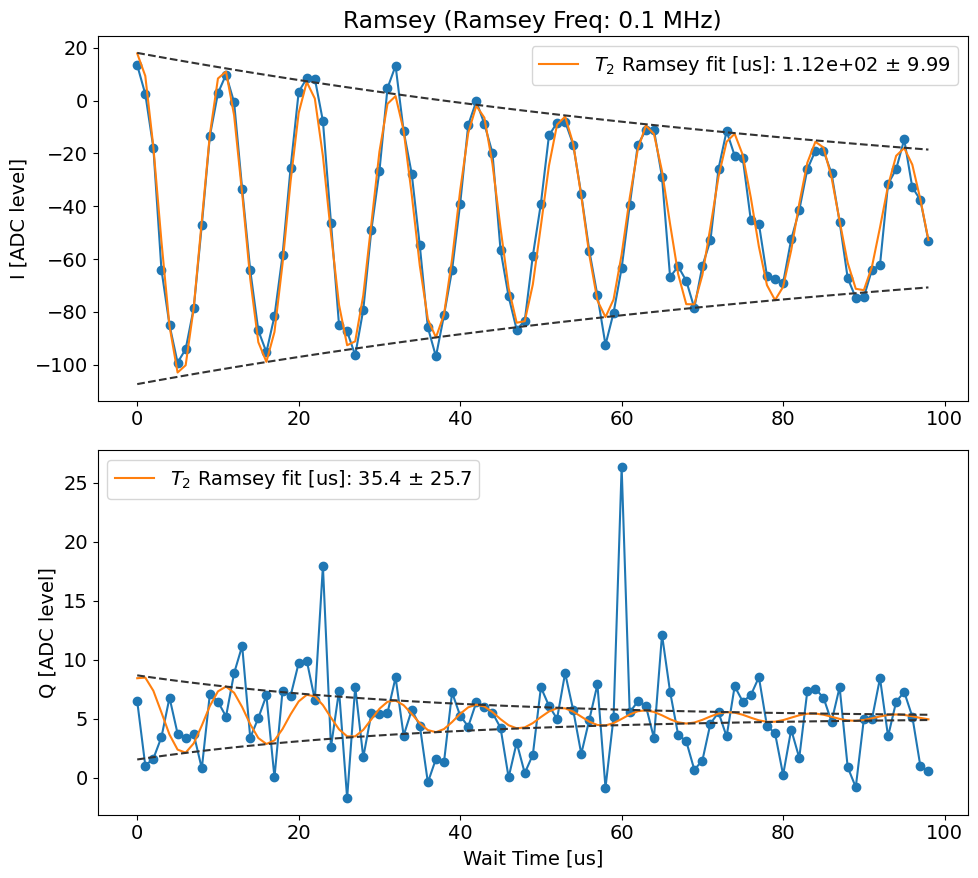

In [ ]:
t2ramsey_ge.analyze()
t2ramsey_ge.display(title_str='T2_ge')

In [ ]:
# config_thisrun.device.qubit.f_ge = yaml_cfg.device.qubit.f_ge

### Amplitude Rabi

We should probably use a cosine fit with fixed phase=0 instead of decaying sine with varying phase?

In [ ]:
def do_amplitude_rabi(
    config_thisrun,
    expt_path,
    config_path,
    start=None,
    step=None,
    expts=151,
    reps=200,
    rounds=1,
    sigma_test=None,
    qubit=0,
    pulse_type='gauss',
    drag_beta=0.0,
    pulse_ge_init=False,
    pulse_ge_after=False,
    checkZZ=False,
    checkEF=False,
    qubits=[0],
    flat_length=0,
    normalize=False,
    single_shot=False,
    singleshot_reps=10000,
    span=50,
    user_defined_freq=[False, 3568.203829046816],
    prepulse=False,
    postpulse=False, 
    if_ef=False,  # If true, will check ef frequency and update it
):
    """
    Run the amplitude Rabi experiment.
    All experiment parameters are function arguments.
    """
    amprabi = meas.single_qubit.amplitude_rabi.AmplitudeRabiExperiment(
        soccfg=soc, path=expt_path, prefix='AmplitudeRabiExperiment', config_file=config_path
    )

    amprabi.cfg = AttrDict(deepcopy(config_thisrun))

    pulse_ge = config_thisrun.device.qubit.pulses.pi_ge
    if sigma_test is None:
        sigma_test = pulse_ge.sigma[0]
    if start is None:
        start = 0
    if step is None:
        step = int(pulse_ge.gain[0] / (expts - 1))
    
    checkEF = False
    pulse_ge_init = False
    pulse_ge_after = False
    if if_ef:
        checkEF = True
        pulse_ge_init = True
        pulse_ge_after = True

    amprabi.cfg.expt = dict(
        start=start,
        step=step,
        expts=expts,
        reps=reps,
        rounds=rounds,
        sigma_test=sigma_test,
        qubit=qubit,
        pulse_type=pulse_type,
        drag_beta=drag_beta,
        pulse_ge_init=pulse_ge_init,
        pulse_ge_after=pulse_ge_after,
        checkZZ=checkZZ,
        checkEF=checkEF,
        qubits=qubits,
        flat_length=flat_length,
        normalize=normalize,
        single_shot=single_shot,
        singleshot_reps=singleshot_reps,
        span=span,
        user_defined_freq=user_defined_freq,
        prepulse=prepulse,
        postpulse=postpulse
    )

    amprabi.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
    amprabi.go(analyze=False, display=False, progress=True, save=True)

    from multimode_expts.fit_display_classes import AmplitudeRabiFitting
    amprabi_analysis = AmplitudeRabiFitting(
        amprabi.data, 
        readout_per_round=4, config=amprabi.cfg,
    )
    return amprabi_analysis


def update_amplitude_rabi(amprabi, config_thisrun):
    """Update the configuration based on amplitude Rabi experiment results."""
    config_thisrun.device.qubit.pulses.pi_ge.gain = [amprabi.data['pi_gain_avgi']]
    config_thisrun.device.qubit.pulses.hpi_ge.gain = [amprabi.data['hpi_gain_avgi']]
    print('Updated qubit ge pi and hpi gaussian gain!')



In [ ]:
amprabi = do_amplitude_rabi(config_thisrun, expt_path, config_path, step = 60)

In [ ]:
# [amplitude, frequency, phase, decay_time, offset, decay_offset]
amprabi.analyze(fitparams=[np.ptp(amprabi.data['avgi'])/2, 0.0001, np.pi, 1000000,None, None])
amprabi.display(title_str='Amplitude Rabi_ge', save_fig=True)
update_amplitude_rabi(amprabi, config_thisrun)

In [ ]:
t2_ramsey_ge_after_amp = None
if expts_to_run['amplitude_ge']:
    # After this do another round of T2 to fine tune the qubit frequency
    t2_ramsey_ge_after_amp  = do_t2_ramsey_ge(config_thisrun, expt_path, config_path,
                                              ramsey_freq=2.0,
                                              step_size=soc.cycles2us(8),
                                              expts=100,
                                              reps=100, active_reset=False, relax_delay=2500)
    t2_ramsey_ge_after_amp.analyze()
    t2_ramsey_ge_after_amp.display(title_str='T2_ge_after_amp')
    update_t2_ramsey_ge(t2_ramsey_ge_after_amp , config_thisrun)
    print('T2 Ramsey done!')

In [ ]:
# amprabi.analyze(fitparams= [np.max(amprabi.data['amps']), 0.00001, 90, None, None, None])
# amprabi.display()
# update_amplitude_rabi(amprabi, config_thisrun)
# print('Amplitude Rabi done!')

In [ ]:
# amprabi.analyze(fitparams= [np.max(amprabi.data['amps']), 0.0001, 90, None, None, None])
# amprabi.display()
# update_amplitude_rabi(amprabi, config_thisrun)


# Magic Params: [np.max(amprabi.data['amps']), 0.00001, 90, None, None, None]

### T1

In [ ]:
def do_t1_ge(config_thisrun, expt_path, config_path):
    """Run the T1 experiment."""
    t1 = meas.single_qubit.t1.T1Experiment(
        soccfg=soc, path=expt_path, prefix='T1Experiment', config_file=config_path
    )

    t1.cfg = AttrDict(deepcopy(config_thisrun))

    t1.cfg.expt = {
        'start': 0,
        'step': 20,
        'expts': 100,
        'reps': 100,
        'rounds': 1,
        'qubit': 0,
        'qubit_ef': False,
        'normalize': False
    }

    t1.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
    t1.go(analyze=True, display=True, progress=True, save=True)
    return t1


def update_t1_ge(t1, config_thisrun):
    """Update the configuration based on T1 experiment results."""
    config_thisrun.device.qubit.T1 = [t1.data['fit_avgi'][3]]
    print('Updated qubit T1!')


  0%|          | 0/10000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00030_T1Experiment.h5
Fit T1 avgi [us]: 356.99927195781254
Fit T1 avgq [us]: 470.2429449379885


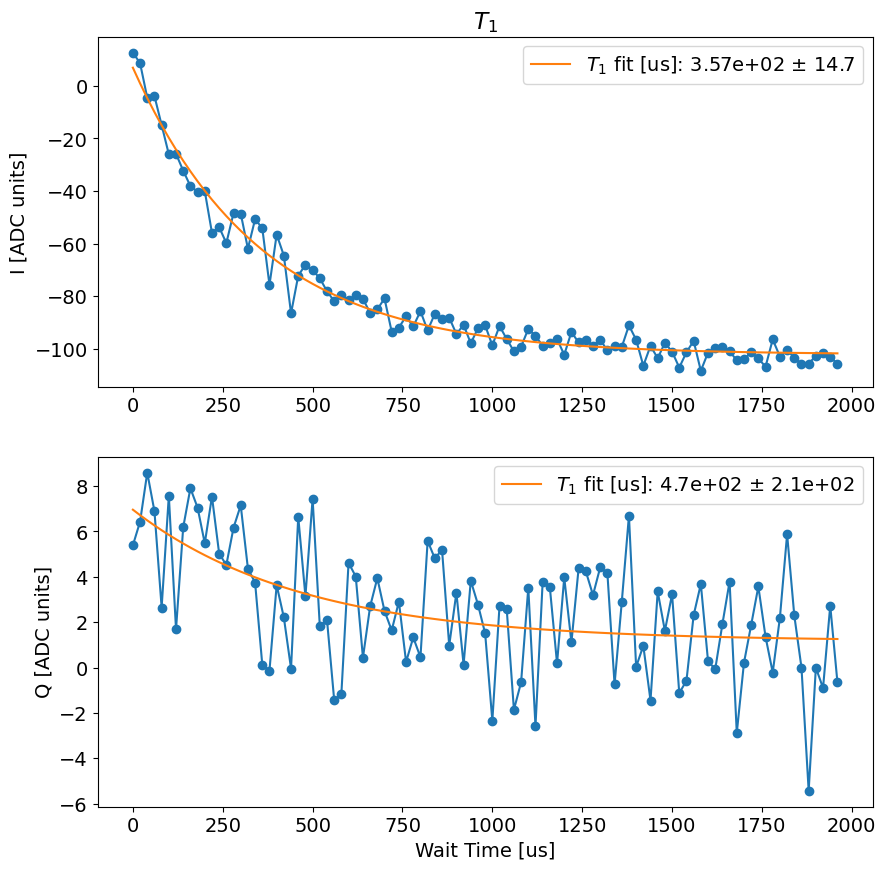

Fit T1 avgi [us]: 356.99927195781254
Fit T1 avgq [us]: 470.2429449379885


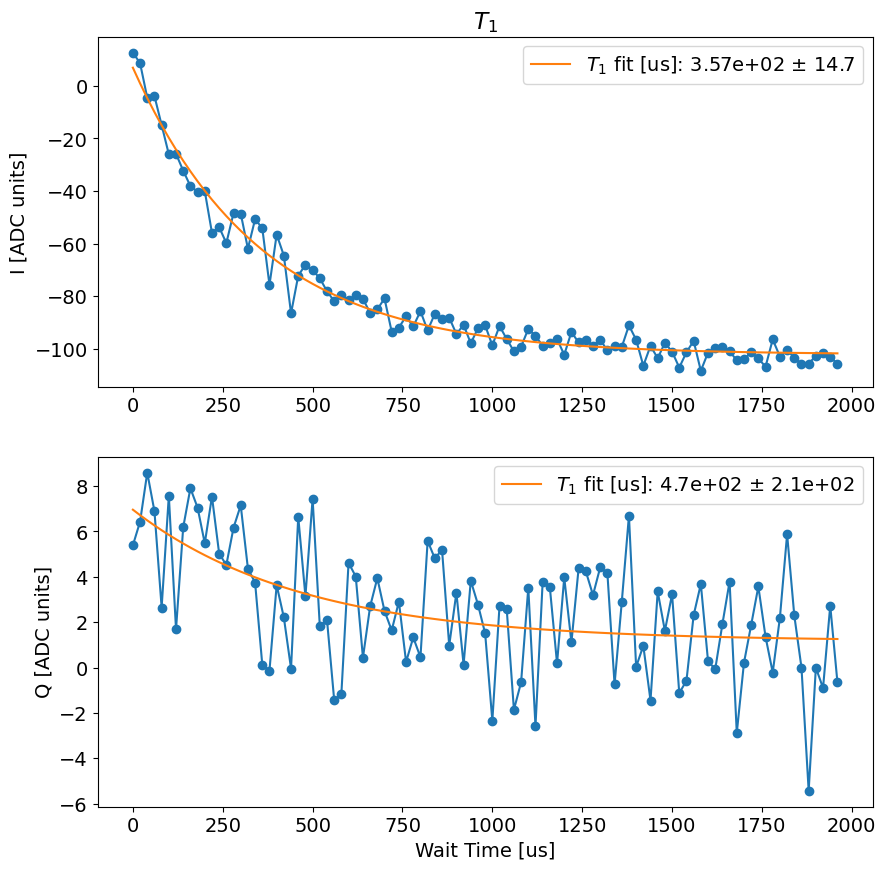

Updated qubit T1!
T1 done!


In [28]:
t1 = None
if expts_to_run['t1_ge']:
    t1 = do_t1_ge(config_thisrun, expt_path, config_path)
    t1.analyze()
    t1.display()
    update_t1_ge(t1, config_thisrun)
    print('T1 done!')

## Qubit ef

### Pulse-probe

In [29]:
def do_pulse_probe_ef(config_thisrun): 

    qspec = meas.single_qubit.pulse_probe_ef_spectroscopy.PulseProbeEFSpectroscopyExperiment(
        soccfg=soc, path=expt_path, prefix='PulseProbeEFSpectroscopyExperiment', config_file=config_path
    )

    qspec.cfg = AttrDict(deepcopy(config_thisrun))

    qspec.cfg.expt = {'start': 3415,
        'step': 0.05,
        'expts': 500,
        'reps': 200,
        'rounds': 1,
        'length': 1,
        'gain': 100,
        # 'pulse_type': 'gaussian',
        'qubit_f': False,
        'qubit': 0,
        'cavity_drive': False,
        'wait_qubit': False,}



    qspec.cfg.device.readout.relax_delay = [500] # Wait time between experiments [us]
    qspec.go(analyze=True, display=True, progress=True, save=True)
    return qspec

def update_pulse_probe_ef(qspec, config_thisrun):
    config_thisrun.device.qubit.f_ef = [qspec.data['fit_avgi'][2]]
    print('Updated qubit frequency!')

In [ ]:
# expts_to_run['pulse_probe_ef'] = True

In [30]:
qspec_ef = None
if expts_to_run['pulse_probe_ef']: 
    qspec_ef = do_pulse_probe_ef(config_thisrun)


  0%|          | 0/100000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
if expts_to_run['pulse_probe_ef']:
    update_pulse_probe_ef(qspec_ef, config_thisrun)
    print('Pulse probe spectroscopy done!')

### T2 Ramsey

In [31]:
def do_t2_ramsey_ef(config_thisrun, expt_path, config_path, ef_init = True, pre_sweep_pulse = None, post_sweep_pulse = None, ramsey_freq = 3, step_size = soc.cycles2us(8), 
                    active_reset = False, relax_delay = 2500, reps = 100):
    """Run the T2 Ramsey experiment."""
    return do_t2_ramsey_ge(config_thisrun, expt_path, config_path, pre_sweep_pulse=pre_sweep_pulse, 
                            post_sweep_pulse=post_sweep_pulse, ramsey_freq=ramsey_freq, step_size=step_size, if_ef=True, ef_init=ef_init,
                            active_reset=active_reset, relax_delay=relax_delay, reps = reps)
    


def update_t2_ramsey_ef(t2ramsey, config_thisrun):
    """Update the configuration based on T2 Ramsey experiment results."""
    config_thisrun.device.qubit.f_ef = [config_thisrun.device.qubit.f_ef[0] + min(t2ramsey.data['f_adjust_ramsey_avgi'])]
    print('Updated qubit ef frequency to:', config_thisrun.device.qubit.f_ef[0])



fge is  3569.6978631006828
fef is  3426.624285537752


  0%|          | 0/20100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00049_RamseyExperiment.h5
No echoes in the data
length 201 201
Attempted to init fitparam 4 to -45.94182313540523, which is out of bounds 0.7404329004329004 to 69.95798701298702. Instead init to 35.34920995670996
Current pi pulse frequency: 3426.624285537752
Fit frequency from I [MHz]: 2.949865663872607 +/- 0.001719733706567196
Suggested new pi pulse frequency from fit I [MHz]:
 	3426.6744198738793
 	3432.5741512016243
T2 Ramsey from fit I [us]: 42.153952373431515
Fit frequency from Q [MHz]: 2.9497912369643555 +/- 0.002322756377560478
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3426.6744943007875
 	3432.574076774716
T2 Ramsey from fit Q [us]: 8.188239085461785


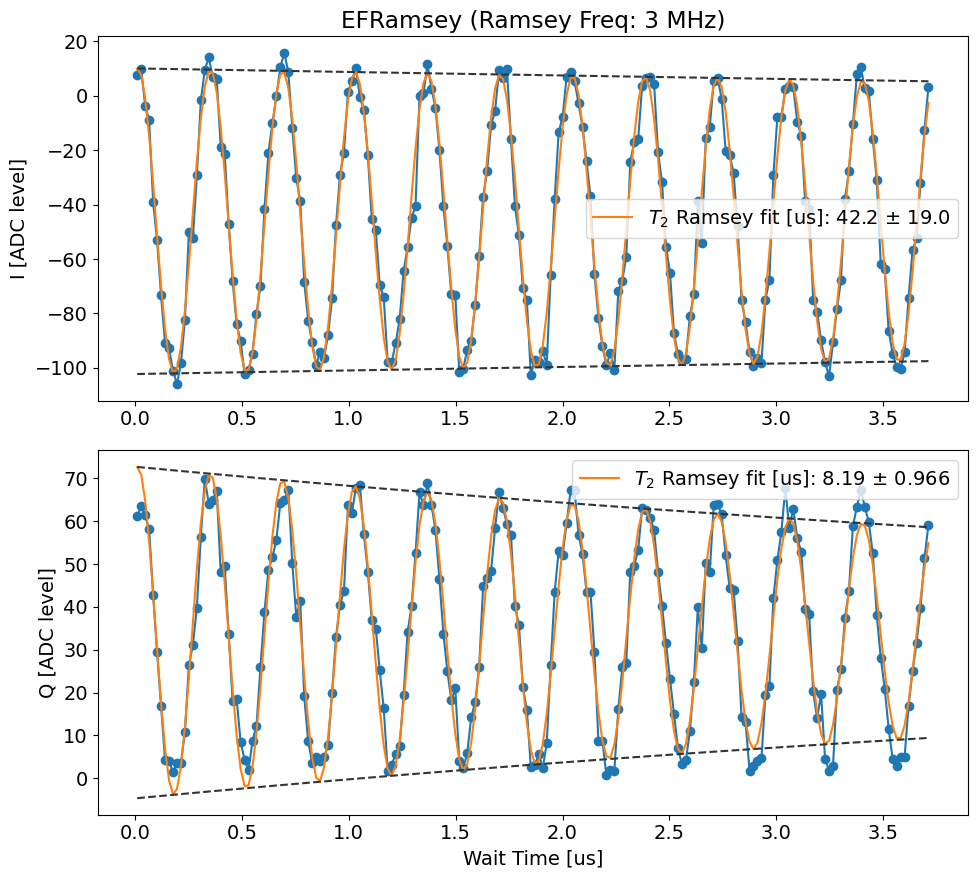

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-09-29_13-51-14_T2_ef.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-09-29.md
T2 Ramsey done!


In [32]:
t2ramsey_ef = None
if expts_to_run['t2_ef']:
    t2ramsey_ef = do_t2_ramsey_ef(config_thisrun, expt_path, config_path)
    t2ramsey_ef.analyze()
    t2ramsey_ef.display(title_str='T2_ef')
    # update_t2_ramsey_ef(t2ramsey_ef, config_thisrun)
    print('T2 Ramsey done!')

In [ ]:
# t2ramsey_ef.analyze(fitparams=[100, 10, None, 20, None, None])
# t2ramsey_ef.display(title_str='T2_ef')
update_t2_ramsey_ef(t2ramsey_ef, config_thisrun)

### Amplitude Rabi

We should probably use a cosine fit with fixed phase=0 instead of decaying sine with varying phase?

In [ ]:
def do_amplitude_rabi_ef(config_thisrun, expt_path, config_path):
    """Run the amplitude Rabi experiment."""
    return do_amplitude_rabi(config_thisrun, expt_path, config_path, step=40, expts=150, if_ef=True)


def update_amplitude_rabi_ef(amprabi, config_thisrun):
    """Update the configuration based on amplitude Rabi experiment results."""
    config_thisrun.device.qubit.pulses.pi_ef.gain = [amprabi.data['pi_gain_avgi']]
    config_thisrun.device.qubit.pulses.hpi_ef.gain = [amprabi.data['hpi_gain_avgi']]
    print('Updated qubit ef pi and hpi gaussian gain!')



In [ ]:
amprabi_ef = do_amplitude_rabi_ef(config_thisrun, expt_path, config_path)
amprabi_ef.analyze(fitparams=[np.max(amprabi_ef.data['amps']), 0.0001, np.pi, 10000,None, None])
amprabi_ef.display(title_str = 'Amplitude Rabi_ef', save_fig=True)


In [ ]:
update_amplitude_rabi_ef(amprabi_ef, config_thisrun)

In [ ]:
amprabi_ef = None
t2_ramsey_ef_after_amp = None
if expts_to_run['amplitude_ef']:
    amprabi_ef = do_amplitude_rabi_ef(config_thisrun, expt_path, config_path)
    amprabi_ef.analyze(fitparams=[np.max(amprabi_ef.data['amps']), 0.0001, np.pi, 10000,None, None])
    amprabi_ef.display(title_str = 'Amplitude Rabi_ef', save_fig=True)
    update_amplitude_rabi_ef(amprabi_ef, config_thisrun)
    print('Amplitude Rabi done!')

    # After this do another round of T2 to fine tune the qubit frequency
    t2_ramsey_ef_after_amp  = do_t2_ramsey_ef(config_thisrun, expt_path, config_path)
    t2_ramsey_ef_after_amp.analyze()
    t2_ramsey_ef_after_amp.display(title_str='T2_ef_after_amp')
    update_t2_ramsey_ef(t2_ramsey_ef_after_amp , config_thisrun)
    print('T2 Ramsey done!')

In [ ]:
# amprabi_ef.analyze(title_str = 'Amplitude Rabi_ef', save_fig=False, fitparams=[np.max(amprabi_ef.data['amps']), 0.0001, 90, None, None, None])
# amprabi_ef.display(title_str = 'Amplitude Rabi_ef', save_fig=False)
# Magic Params: [np.max(amprabi_ef.data['amps']), 0.00001, 90, None, None, None]

In [ ]:
# update_amplitude_rabi_ef(amprabi_ef, config_thisrun)
# print('Amplitude Rabi done!')

# # After this do another round of T2 to fine tune the qubit frequency
# t2_ramsey_ef_after_amp  = do_t2_ramsey_ef(config_thisrun, expt_path, config_path)
# t2_ramsey_ef_after_amp.analyze()
# t2_ramsey_ef_after_amp.display(title_str='T2_ef_after_amp')
# update_t2_ramsey_ef(t2_ramsey_ef_after_amp , config_thisrun)
# print('T2 Ramsey done!')

In [ ]:
# t2_ramsey_ef_after_amp.analyze(fitparams=[300, None, None, None, None, None])
# t2_ramsey_ef_after_amp.display(title_str='T2_ef_after_amp')
# update_t2_ramsey_ef(t2_ramsey_ef_after_amp , config_thisrun)

### T1

In [ ]:
def do_t1_ef(config_thisrun, expt_path, config_path):
    """Run the T1 experiment."""
    t1 = meas.single_qubit.t1.T1Experiment(
        soccfg=soc, path=expt_path, prefix='T1Experiment', config_file=config_path
    )

    t1.cfg = AttrDict(deepcopy(config_thisrun))

    t1.cfg.expt = {
        'start': 0,
        'step': 5,
        'expts': 100,
        'reps': 50,
        'rounds': 1,
        'qubit': 0,
        'qubit_ef': True,
        'normalize': False
    }

    t1.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
    t1.go(analyze=True, display=True, progress=True, save=True)
    return t1


def update_t1_ef(t1, config_thisrun):
    """Update the configuration based on T1 experiment results."""
    config_thisrun.device.qubit.T1_ef = [t1.data['fit_avgq'][3]]
    print('Updated qubit T1!')


In [ ]:
t1_ef = None
if expts_to_run['t1_ef']:
    t1 = do_t1_ef(config_thisrun, expt_path, config_path)
    t1.analyze()
    t1.display()
    update_t1_ef(t1, config_thisrun)
    print('T1 done!')

# Manipulate

## Spectroscopy

In [ ]:
def do_pulse_probe_f0g1(config_thisrun, ds_thisrun, man_mode_no = 1): 

    qspec = meas.single_qubit.pulse_probe_f0g1_spectroscopy.PulseProbeF0g1SpectroscopyExperiment(
        soccfg=soc, path=expt_path, prefix='PulseProbeF0g1SpectroscopyExperiment', config_file=config_path
    )

    qspec.cfg = AttrDict(deepcopy(config_thisrun))

    qspec.cfg.expt = {
        'start': ds_thisrun.get_freq('M' + str(man_mode_no)) - 10,  # resonator frequency to be mixed up [MHz]
        'step': 0.1,  # min step ~1 MHz
        'expts': 200,  # Number of experiments stepping from start
        'reps': 100,  # Number of averages per point
        'rounds': 1,  # Number of start to finish sweeps to average over
        'length': 1,  # ef probe constant pulse length [us]
        'gain': 3000,  # f0g1 pulse gain
        'pulse_type': 'gaussian',
        'qubit_f': True,
        'qubits': [0],
        'prepulse': False,
        'pre_sweep_pulse': [[3569.4827896982997], [11161], [0], [0], [2], ['g'], [0.035]]
    }

    qspec.cfg.device.readout.relax_delay = [200] # Wait time between experiments [us]
    qspec.go(analyze=False, display=False, progress=True, save=True)
    return qspec

def analyze_and_display_pulse_probe_f0g1(qspec):
    from multimode_expts.fit_display_classes import Spectroscopy
    spec_analysis = Spectroscopy(
        qspec.data)
    spec_analysis.analyze(fit=True)
    spec_analysis.display()

def update_pulse_probe_f0g1(qspec, config_thisrun, man_mode_no = 1):
    ''' 
    Update the configuration based on f0g1 spectroscopy experiment results.
    man_mode_no: 1 for man1, 2 for man2
    '''
    ds_thisrun.update_freq('M' + str(man_mode_no),  qspec.data['fit_avgi'][2])
    config_thisrun.device.multiphoton['pi']['fn-gn+1']['frequency'][0] = qspec.data['fit_avgi'][2]


    print('Updated man f0g1 freq to :', ds_thisrun.get_freq('M1'))


In [ ]:
# expts_to_run['pulse_probe_f0g1'] = True

In [ ]:
man_specs =[None]* len(expts_to_run['man_modes'])

for i in range(len(expts_to_run['man_modes'])):

    if expts_to_run['pulse_probe_f0g1']:

        print('Running pulse probe f0g1 for mode', i+1)
        man_specs[i] = do_pulse_probe_f0g1(config_thisrun, ds_thisrun, man_mode_no = i+1)
        analyze_and_display_pulse_probe_f0g1(man_specs[i])
        update_pulse_probe_f0g1(man_specs[i], config_thisrun, man_mode_no=i+1)
        
        

## Find Frequency (Chevron)


In [ ]:
%matplotlib inline

In [33]:
def do_length_rabi_f0g1_sweep(config_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step):
    """Run the Length Rabi General F0g1 Experiment Sweep."""
    # length_rabi = meas.single_qubit.length_rabi.LengthRabiGeneralF0g1ExperimentSweep(
    #     soccfg=soc, path=expt_path, prefix='LengthRabiGeneralF0g1ExperimentSweep', config_file=config_path
    # )
    from multimode_expts.sequential_experiment_classes import man_f0g1_class
    experiment_class = man_f0g1_class
    sweep_experiment_name = 'length_rabi_f0g1_sweep'
    class_for_exp = experiment_class(soccfg=soc, path=expt_path, prefix=sweep_experiment_name, config_file=config_path,
                                      exp_param_file=exp_param_file, config_thisrun=config_thisrun)

    # class_for_exp.yaml_cfg = AttrDict(deepcopy(config_thisrun))
    
    class_for_exp.loaded[sweep_experiment_name] = {
        'freq_start': freq_start,
        'freq_stop':  freq_stop,
        'freq_step': freq_step,
        'start': 5,
        'step': 0.02,
        'qubits': [0],
        'expts': 101,
        'reps': 100,
        'rounds': 1,
        'gain': 8000,
        'ramp_sigma': 0.005,
        'use_arb_waveform': False,
        'pi_ge_before': True,
        'pi_ef_before': True,
        'pi_ge_after': False,
        'normalize': False,
        'active_reset': True,
        'check_man_reset': [False, 0],
        'check_man_reset_pi': [],
        'prepulse': False,
        'pre_sweep_pulse': [],
        'err_amp_reps' : 0, # Number of error amp rounds
    } # actually this doesn't do anything, edit experiment.yml
    
 
    return eval('class_for_exp.run_sweep')( sweep_experiment_name = sweep_experiment_name)

def update_length_rabi_f0g1_sweep(expt_path, prefix, config_thisrun, man_mode_no = 1):
    """Update sweep data and analyze results."""
    temp_data, attrs, filename = prev_data(expt_path, prefix=prefix)
    print('File saved at :', filename)
    from multimode_expts.fit_display_classes import ChevronFitting
    from datetime import datetime
    
    chevron_analysis = ChevronFitting(
        frequencies=temp_data['freq_sweep'],
        time=temp_data['xpts'][0],
        response_matrix=temp_data['avgi'],
        config = config_thisrun
    )
    chevron_analysis.analyze()
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    chevron_analysis.display_results(save_fig=True,  title=f'M{man_mode_no}_{current_time}')

    #config_thisrun.device.manipulate.f0g1_freq[0] = chevron_analysis.results['frequency']
    ds_thisrun.update_freq('M' + str(man_mode_no), chevron_analysis.results['best_frequency_contrast'])
    print('Updated the frequency to:', chevron_analysis.results['best_frequency_contrast'])
    return chevron_analysis


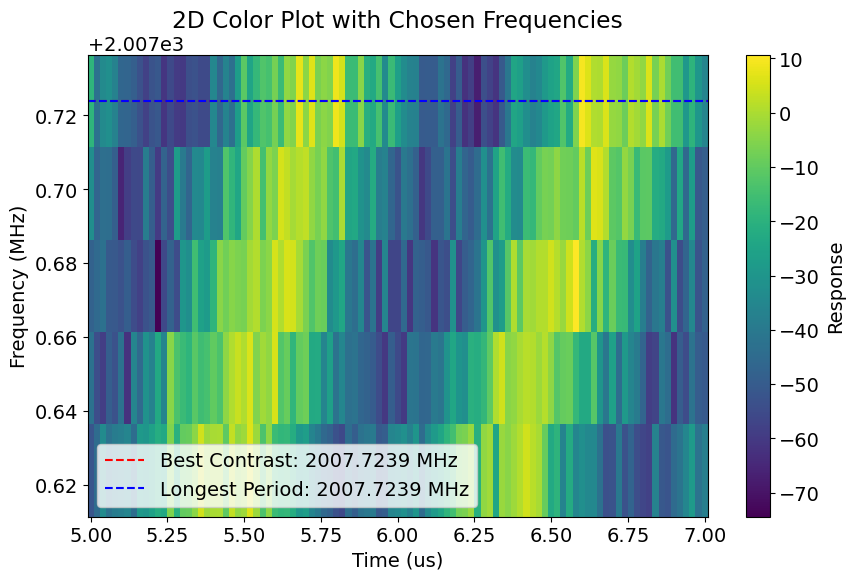

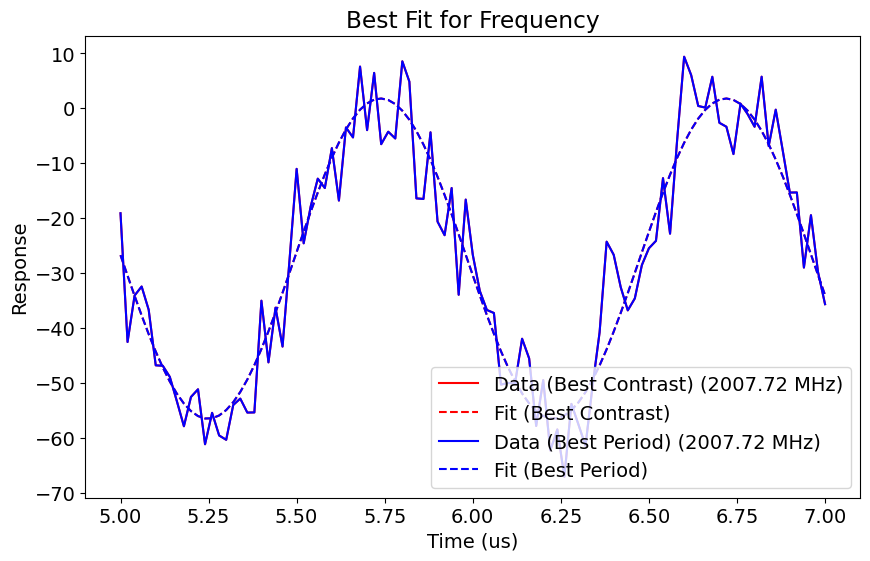

Index: 5 Freq. = 2007.7488939682348 GHz
Running experiment with config: configthisrun
Doesn’t make sense to active reset in this experiment
{'start': 5, 'step': 0.02, 'qubits': [0], 'expts': 101, 'reps': 100, 'rounds': 1, 'gain': 8000, 'freq': 2007.7488939682348, 'use_arb_waveform': False, 'pi_ge_before': True, 'pi_ef_before': True, 'pi_ge_after': False, 'pi_ef_after': False, 'normalize': False, 'active_reset': True, 'check_man_reset': [False, 0], 'swap_lossy': False, 'check_man_reset_pi': [], 'prepulse': False, 'pre_sweep_pulse': [], 'err_amp_reps': 0}


KeyboardInterrupt: 

In [34]:
man_chevrons_coarse = [None] * len(expts_to_run['man_modes'])
man_chevrons_fine = [None] * len(expts_to_run['man_modes'])
# man_sweeps = [None] * len(expts_to_run['man_modes'])

for i in range(len(expts_to_run['man_modes'])):
    if expts_to_run['length_rabi_sweep']:
        print(f'Running coarse length rabi sweep for mode {i + 1}')
        # freq_start = ds_thisrun.get_freq('M' + str(i + 1)) - 3
        # freq_stop = ds_thisrun.get_freq('M' + str(i + 1)) + 3
        # freq_step = 0.3
        # man_chevrons_coarse[i] = do_length_rabi_f0g1_sweep(config_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step)
        # update_length_rabi_f0g1_sweep(expt_path, 'length_rabi_f0g1_sweep', config_thisrun, man_mode_no=i + 1)

        print(f'Running fine length rabi sweep for mode {i + 1}')
        freq_start = ds_thisrun.get_freq('M' + str(i + 1)) - 0.2
        freq_stop = ds_thisrun.get_freq('M' + str(i + 1)) + 0.2
        freq_step = 0.025
        man_chevrons_fine[i] = do_length_rabi_f0g1_sweep(config_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step)
        update_length_rabi_f0g1_sweep(expt_path, 'length_rabi_f0g1_sweep', config_thisrun, man_mode_no=i + 1)

In [ ]:
ds_thisrun.update_freq('M1', 2007.86)

## Error amplification

In [ ]:
from MM_dual_rail_base import MM_dual_rail_base
mm_base_calib = MM_dual_rail_base(config_thisrun, ds_thisrun)

sideband = 'f0-g1'
_sideband = sideband[0] + 'n' + '-' + sideband[3] + 'n+1'
i = int(sideband[1])
pre_sweep_pulse = mm_base_calib.prep_man_photon(man_no=1, photon_no=i)
print(f"pre_sweep_pulse: {pre_sweep_pulse}")
pre_sweep_pulse.append(['multiphoton', 'g'+str(i)+'-e'+str(i), 'pi', 0])
pre_sweep_pulse.append(['multiphoton', 'e'+str(i)+'-f'+str(i), 'pi', 0])
# pre_sweep_pulse = mm_base_calib.get_prepulse_creator(pre_sweep_pulse, multiphoton_cfg_thisrun).pulse.tolist()
pre_sweep_pulse = mm_base_calib.get_prepulse_creator(pre_sweep_pulse, config_thisrun).pulse.tolist()
# print(f"pre_sweep_pulse: {pre_sweep_pulse}")

In [ ]:
def do_error_amplification(
    config_thisrun,
    expt_path,
    config_path,
    reps=100,
    rounds=1,
    qubit=0,
    n_pulses=10,
    active_reset=False,
    man_reset=True,
    storage_reset=True,
    relax_delay=2500, 
    start = 0,
    expts = 10,
    step = 100,
    parameter_to_test = 'gain',
    pulse_type=['qubit', 'ge', 'pi', 0],
):
    """
    Run the Histogram Prepulse Experiment with configurable parameters.
    """
        
    expt_cfg = {
        'reps': reps,
        'qubit': qubit,
        'qubits': [qubit],
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'start': start,
        'expts': expts,
        'step': step,
        'n_pulses': n_pulses,
        'pulse_type': pulse_type,
        'parameter_to_test': parameter_to_test,
        'rounds': rounds,

    }
    error_amp_exp = meas.single_qubit.error_amplification.ErrorAmplificationExperiment(
    soccfg=soc, path=expt_path,
      prefix='ErrorAmplificationExperiment', config_file=config_path)
    error_amp_exp.cfg = AttrDict(deepcopy(config_thisrun))
    error_amp_exp.cfg.expt = expt_cfg
    error_amp_exp.go(analyze=False, display=False, progress=True, save=True)
    return error_amp_exp

In [ ]:
 config_thisrun.device.multiphoton['pi'][_sideband]['frequency'][i]

In [ ]:
expts = 20
# band = 0.75
band = 0.5
# config_thisrun.device.multiphoton['pi'][_sideband]['length'][0] = 0.5491206701698654
freq_start = config_thisrun.device.multiphoton['pi'][_sideband]['frequency'][i] - band
# freq_start = 2011 - band
step = 2 * band / expts
print(f'Frequency start: {freq_start}, Step: {step}')

err_amp_man_freq = do_error_amplification(
    config_thisrun=config_thisrun,
    expt_path=expt_path,
    config_path=config_file,
    reps=100,
    rounds=1,
    n_pulses = 7,
    expts=expts,
    start=freq_start,
    step=step,
    pulse_type=['multiphoton', sideband, 'pi', 0],
    parameter_to_test='frequency',
)

In [ ]:
err_amp_man_freq.analyze(state_fin='e')
err_amp_man_freq.display()

In [ ]:
print(f"Man {sideband} pi frequency before update:", config_thisrun.device.multiphoton['pi'][_sideband]['frequency'][i])
config_thisrun.device.multiphoton['pi'][_sideband]['frequency'][i] = err_amp_man_freq.data['fit_avgi'][2]
print(f"Man {sideband} pi frequency after update:", config_thisrun.device.multiphoton['pi'][_sideband]['frequency'][i])

In [ ]:
if i > 0:
    print("WARNING! No update will occur! The update in this cell was meant for the csv which does not have multiphoton params. To update the multiphoton params, please run the multiphoton calibration notebook instead.")
else:
    ds_thisrun.update_freq('M1', err_amp_man_freq.data['fit_avgi'][2])
    print("Updated the ds_thisrun frequency to:", ds_thisrun.get_freq('M1'))

## Length Rabi f0g1 (Update time)

In [54]:
def do_length_rabi_f0g1_general(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no = 1):
    """Run the Length Rabi General F0g1 Experiment."""
    length_rabi = meas.single_qubit.length_rabi_f0g1_general.LengthRabiGeneralF0g1Experiment(
        soccfg=soc, path=expt_path, prefix='LengthRabiGeneralF0g1Experiment', config_file=config_path
    )

    length_rabi.cfg = AttrDict(deepcopy(config_thisrun))

    length_rabi.cfg.expt = dict(
        start=soc.cycles2us(3),  # Pulse start length [us]
        step=0.05,  # Pulse step length [us]
        qubits=[0],
        expts=150,
        reps=100,
        rounds=1,
        # rep_start=0, # 0 means just 1 pi pulse, no error amp
        # rep_end=19, # will do 1+2*rep_end rounds of pi pulses max
        gain=8000,  # Qubit gain [DAC units]
        freq= ds_thisrun.get_freq('M' + str(man_mode_no)),  # Frequency [MHz]
        use_arb_waveform=False,
        pi_ge_before=True,
        pi_ef_before=True,
        pi_ge_after=True,
        # pi_ef_after=True,
        normalize=False,
        active_reset=True,
        man_reset=True,
        stor_reset=True,
        check_man_reset=[False, 0],
        swap_lossy=False,
        check_man_reset_pi=[],
        prepulse=False,
        pre_sweep_pulse=[],
        err_amp_reps = 0, # Number of error amp rounds
    )

    length_rabi.cfg.device.readout.relax_delay = [20]  # Wait time between experiments [us]
    length_rabi.go(analyze=False, display=False, progress=True, save=True)

    from multimode_expts.fit_display_classes import LengthRabiFitting
    # Analyze the data
    length_rabi_analysis = LengthRabiFitting(length_rabi.data, config = length_rabi.cfg)
    length_rabi_analysis.analyze()
    length_rabi_analysis.display(title_str='Length Rabi General F0g1')


    return length_rabi_analysis


def update_length_rabi_f0g1_combined(length_rabi, config_thisrun, ds, man_mode_no = 1):
    """Update the configuration and dataset based on Length Rabi General F0g1 experiment results."""

    # Update dataset
    pi_length = length_rabi.results['pi_length']
    pi2_length = length_rabi.results['pi2_length']
    gain = length_rabi.cfg.expt['gain']
    freq = length_rabi.cfg.expt['freq']
    ds.update_all('M' + str(man_mode_no), freq, np.nan, pi_length, pi2_length, gain)
    print(f'Updated dataset: pi_length={pi_length}, pi2_length={pi2_length}, gain={gain}')



Running length rabi for mode 1


  0%|          | 0/150 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00002_LengthRabiGeneralF0g1Experiment.h5
p1: 0.644442096777208
p2: 147.63538586328858
Pi length: 0.5274356030357494
Pi/2 length: 0.13950315534149482
p1: 4.301715612147965
p2: 89.56140618819703
Pi length: 0.11651591163499184
Pi/2 length: 0.0583995639866246


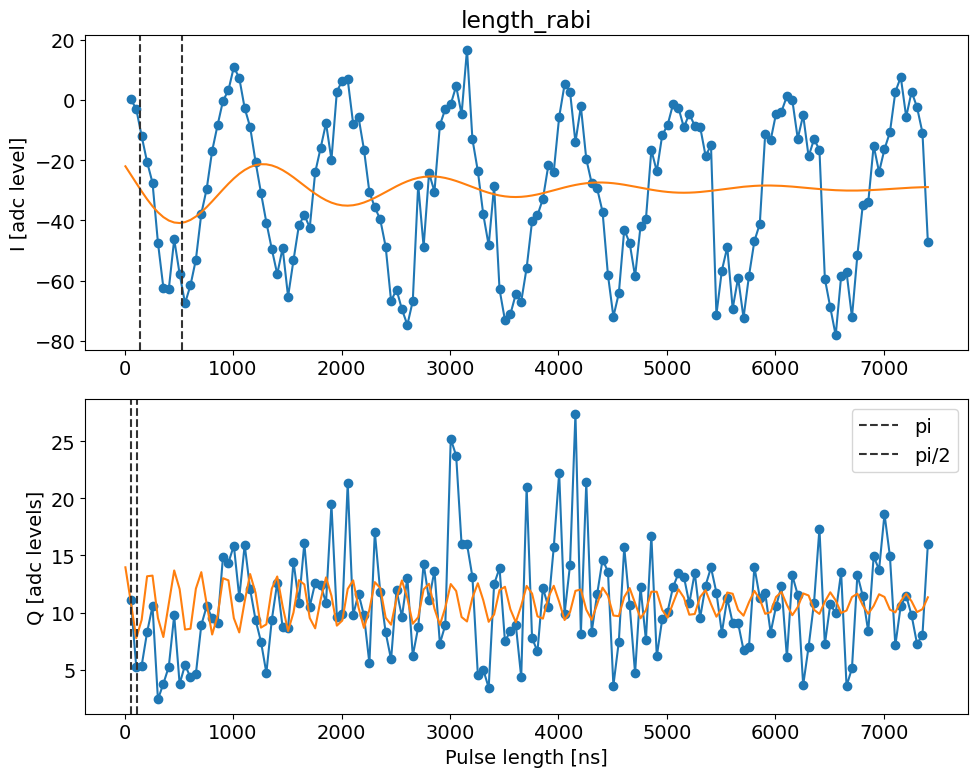

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-09-29_13-00-02_Length_Rabi_General_F0g1.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-09-29.md
Creating or updating new csv at path: man1_storage_swap_dataset_copy.csv
Updated dataset: pi_length=0.5274356030357494, pi2_length=0.13950315534149482, gain=8000


In [55]:
len_rabis_mans = [None]* len(expts_to_run['man_modes'])
for i in range(len(expts_to_run['man_modes'])):
    if expts_to_run['length_rabi'] or expts_to_run['length_rabi_sweep']:
        print('Running length rabi for mode', i+1)
        len_rabis_mans[i] = do_length_rabi_f0g1_general(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no= i+1)
        update_length_rabi_f0g1_combined(len_rabis_mans[i], config_thisrun, ds_thisrun, man_mode_no= i+1)

In [ ]:
# len_rabis_mans[0].active_reset = True
# len_rabis_mans[0].analyze()
# len_rabis_mans[0].display(title_str='Length Rabi General F0g1')

In [ ]:
# idata = len_rabis_mans[0].data['idata']
# idata = idata.reshape((len(idata.flatten())//4,4))

# qdata = len_rabis_mans[0].data['qdata']
# qdata = qdata.reshape((len(qdata.flatten())//4,4))

# fig, axs = plt.subplots(nrows=4,ncols=2, figsize=(8,8))
# for kk in range(4):
#     axs[kk,0].hist(idata[:,kk], bins=100)
#     axs[kk,1].hist(qdata[:,kk], bins=100)
# None

### Quick and dirty error amplification

Very slightly modified length rabi f0g1 general (see git)

In [ ]:
def length_rabi_f0g1_err_amp(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no = 1):
    """Run the Length Rabi General F0g1 repeatedly to amplify error."""

    expt_cfg = dict(
        start=ds_thisrun.get_pi('M1')-soc.cycles2us(1)*50,  # Pulse start length [us]
        step=soc.cycles2us(1),  # Pulse step length [us]
        qubits=[0],
        expts=100,
        reps=200,
        rounds=1,
        rep_start=0, # 0 means just 1 pi pulse, no error amp
        rep_end=19, # will do 1+2*rep_end rounds of pi pulses max
        gain=15000,  # Qubit gain [DAC units]
        freq= ds_thisrun.get_freq('M' + str(man_mode_no)),  # Frequency [MHz]
        use_arb_waveform=False,
        pi_ge_before=True,
        pi_ef_before=True,
        pi_ef_after=True,
        normalize=False,
        active_reset=False,
        check_man_reset=[False, 0],
        swap_lossy=False,
        check_man_reset_pi=[],
        prepulse=False,
        pre_sweep_pulse=[]
    )

    for err_amp_reps in tqdm(range(expt_cfg['rep_start'], expt_cfg['rep_end'] + 1)):
        length_rabi = meas.single_qubit.length_rabi_f0g1_general.LengthRabiGeneralF0g1Experiment(
            soccfg=soc, path=expt_path, prefix='LengthRabiGeneralF0g1Experiment', config_file=config_path
        )

        length_rabi.cfg = AttrDict(deepcopy(config_thisrun))

        expt_cfg['err_amp_reps'] = err_amp_reps

        length_rabi.cfg.expt = expt_cfg

        length_rabi.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
        length_rabi.go(analyze=False, display=False, progress=False, save=True)
    return length_rabi

In [ ]:
# length_rabi_f0g1_err_amp(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no=1)

In [ ]:
# lines = []
# ypts = []
# for prefix_num in range(43,63):
#     fname = f'{prefix_num:05d}_LengthRabiGeneralF0g1Experiment.h5'
#     temp_data, attrs, filename = prev_data(expt_path, fname)
#     ypts.append(attrs['config']['expt']['err_amp_reps'])
#     lines.append(temp_data['avgi'])
    
# xpts = temp_data['xpts']
# ypts = np.array(ypts)
# lines = np.array(lines)

# import matplotlib.pyplot as plt


# plt.figure(figsize=(8, 6))
# plt.pcolormesh(xpts, ypts, lines, shading='auto', cmap='viridis')
# # add vertical line at dsthisrun.get_pi('M1')
# plt.axvline(x=ds_thisrun.get_pi('M1'), color='r', linestyle='--', label='Old calib Pi Pulse Length')

# # add vertical line where the new calib pi pulse length is
# lines_processed = np.abs(np.prod((lines-lines.mean())/(np.max(lines)-lines.mean()), axis=0))
# xmax = np.argmax(lines_processed)
                          
# plt.axvline(x=xpts[xmax], color='g', linestyle='--', label='New calib Pi Pulse Length')
# # in legend mention the difference between the two
# diff = xpts[xmax] - ds_thisrun.get_pi('M1')
# plt.legend(title=f'ΔPi = {diff:.5f} us')
# plt.xlabel('Pulse Length [us]')
# plt.ylabel('Error Amplification Reps')
# plt.title('Length Rabi Error Amplification')
# plt.colorbar(label='Signal (avgi)')
# plt.show()


In [ ]:
# lines_processed = np.abs(np.prod((lines-lines.mean())/(np.max(lines)-lines.mean()), axis=0))
# xmax = np.argmax(lines_processed)
                          
# plt.plot(lines_processed, marker='o')
# plt.axvline(x=xmax, color='r', linestyle='--')


### and amplitude

In [ ]:
def amp_rabi_f0g1_err_amp(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no = 1):
    """Run the Length Rabi General F0g1 repeatedly to amplify error."""

    expt_cfg = dict(
        start=ds_thisrun.get_gain(f'M{man_mode_no}')-50*50,  # Pulse start length [dac unit]
        step=50,  # Pulse step length [dac unit]
        qubits=[0],
        expts=100,
        reps=200,
        rounds=1,
        rep_start=0,
        rep_end=19,
        # gain=15000,  # Qubit gain [DAC units]
        ramp_sigma=0.005,  # Ramp sigma [us]
        freq= ds_thisrun.get_freq('M' + str(man_mode_no)),  # Frequency [MHz]
        length= ds_thisrun.get_pi(f'M{man_mode_no}'),
        use_arb_waveform=False,
        pi_ge_before=True,
        pi_ef_before=True,
        pi_ef_after=True,
        normalize=False,
        active_reset=False,
        check_man_reset=[False, 0],
        swap_lossy=False,
        check_man_reset_pi=[],
        prepulse=False,
        pre_sweep_pulse=[]
    )

    for err_amp_reps in tqdm(range(expt_cfg['rep_start'], expt_cfg['rep_end'] + 1)):
        amp_rabi = meas.single_qubit.amplitude_rabi_f0g1_general.AmplitudeRabiGeneralF0g1Experiment(
            soccfg=soc, path=expt_path, prefix='AmplitudeRabiGeneralF0g1Experiment', config_file=config_path
        )

        amp_rabi.cfg = AttrDict(deepcopy(config_thisrun))

        expt_cfg['err_amp_reps'] = err_amp_reps

        amp_rabi.cfg.expt = expt_cfg

        amp_rabi.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
        amp_rabi.go(analyze=False, display=False, progress=False, save=True)
    return amp_rabi

In [ ]:
# amp_rabi_f0g1_err_amp(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no=1)
    # 

In [ ]:
# lines = []
# ypts = []
# for prefix_num in range(15,35):
#     fname = f'{prefix_num:05d}_AmplitudeRabiGeneralF0g1Experiment.h5'
#     temp_data, attrs, filename = prev_data(expt_path, fname)
#     lines.append(temp_data['avgi'])
#     ypts.append(attrs['config']['expt']['err_amp_reps'])
# xpts = temp_data['xpts']

# lines = np.array(lines)
# ypts = np.array(ypts)

# plt.figure(figsize=(8, 6))
# plt.pcolormesh(xpts, ypts, lines, shading='auto', cmap='viridis')
# plt.axvline(x=ds_thisrun.get_gain('M1'), color='r', linestyle='--', label='Old calib Gain')
# plt.xlabel('Pulse Length [us]')
# plt.ylabel('Error Amplification Reps')
# plt.title('Amplitude Rabi Error Amplification')
# plt.colorbar(label='Signal (avgi)')
# plt.legend()
# plt.show()

In [ ]:
# lines_processed = np.abs(np.prod((lines-lines.mean())/(np.max(lines)-lines.mean()), axis=0))
# xmax = np.argmax(lines_processed)
                          
# plt.plot(lines_processed, marker='o')
# plt.axvline(x=xmax, color='r', linestyle='--')

## Chi between qubit and Manipulate 

### ge

In [35]:
from MM_dual_rail_base import MM_dual_rail_base
import numpy as np

# the do function contains 2 calls to ramsey, one with no prepulse and one with prepulse 
# that initializes manipulation mode to 1 state
# do_t2_ramsey_ge is already defined in previous cells and can be used directly

# Add active_reset, relax_delay, expts as arguments and pass them to do_t2_ramsey_ge
def do_chi(config_thisrun, expt_path, config_path, prepulse=None, standard_ramsey=True,
           man_mode_no=1, active_reset=False, relax_delay=2500, expts=100):
    """
    Run two Ramsey experiments: one standard, one with a prepulse that initializes manipulation mode 1.
    Returns both experiment objects.
    """
    # Standard Ramsey (no prepulse)
    if standard_ramsey:
        t2ramsey_no_prepulse = do_t2_ramsey_ge(
            config_thisrun, expt_path, config_path,
            pre_sweep_pulse=None, post_sweep_pulse=None,
            step_size=0.1,
            active_reset=active_reset,
            relax_delay=relax_delay,
            expts=expts
        )
    else: 
        t2ramsey_no_prepulse = None

    # Ramsey with prepulse (initialize manipulation mode 1)
    if prepulse is None:
        mm_base_dummy = MM_dual_rail_base(config_thisrun)
        prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
        prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()

    t2ramsey_with_prepulse = do_t2_ramsey_ge(
        config_thisrun, expt_path, config_path,
        pre_sweep_pulse=prepulse, post_sweep_pulse=None,
        step_size=0.1,
        active_reset=active_reset,
        relax_delay=relax_delay,
        expts=expts
    )

    return t2ramsey_no_prepulse, t2ramsey_with_prepulse


def update_chi(t2_ramsey_original, t2_ramsey_prepulse, config_thisrun, man_mode_no=1):
    """
    Update config_thisrun.device.qubit.chi for the given manipulation mode.
    """
    f_without_prepulse = t2_ramsey_original.data['f_adjust_ramsey_avgi'][0]
    f_with_prepulse = t2_ramsey_prepulse.data['f_adjust_ramsey_avgi'][0]
    chi = f_with_prepulse - f_without_prepulse
    print('Chi:', chi)
    config_thisrun.device.manipulate.chi_ge[man_mode_no - 1] = chi
    config_thisrun.device.manipulate.revival_time[man_mode_no-1] = np.abs(np.pi/(2 * np.pi * chi))
    print('Delay time (mus):', config_thisrun.device.manipulate.revival_time[man_mode_no-1] )


In [36]:
t2_ramsey_original, t2_ramsey_prepulse = None, None
# Run the chi experiments/__pycache__/
if expts_to_run['chi_ge']:
    t2_ramsey_original, t2_ramsey_prepulse = do_chi(config_thisrun, expt_path, config_path, standard_ramsey=True)
    # analyze and display the results
    t2_ramsey_original.analyze(fitparams=[300, None, None, None, None, None])
    t2_ramsey_original.display()
    t2_ramsey_prepulse.analyze(fitparams=[300, None, None, None, None, None])
    t2_ramsey_prepulse.display() 
    # update the config_thisrun with the chi value
    update_chi(t2_ramsey_original, t2_ramsey_prepulse, config_thisrun, man_mode_no=1)
    print('Only doing it for mode 1')

fge is  3569.6978631006828
fef is  3426.624285537752


  0%|          | 0/20000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00050_RamseyExperiment.h5


TypeError: __init__() missing 1 required positional argument: 'soccfg'

In [ ]:
# config_thisrun.device.manipulate.revival_time[0] = np.pi/(2 * np.pi * config_thisrun.device.manipulate.chi[0])

### ef

In [ ]:
from MM_dual_rail_base import MM_dual_rail_base

# the do function contains 2 calls to ramsey, one with no prepulse and one with prepulse 
# that initializes manipulation mode to 1 state
def do_chi_f(config_thisrun, expt_path, config_path, 
           man_mode_no=1):
    """
    Run two Ramsey experiments: one standard, one with a prepulse that initializes manipulation mode 1.
    Returns both experiment objects.
    """

    
    mm_base_dummy = MM_dual_rail_base(config_thisrun)
    prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
    # Add qubit ge prepulse and postpulse for ef (ge init)
    qubit_ge_prepulse = [['qubit', 'ge', 'pi', 0]]
    prep_man_pi_prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()
    prepulse =  mm_base_dummy.get_prepulse_creator(prep_man_pi + qubit_ge_prepulse ).pulse.tolist() 
    postpulse  = mm_base_dummy.get_prepulse_creator(qubit_ge_prepulse).pulse.tolist()

    # Add chi to frequency of qubit ge 
    # prepulse[0][-1] += config_thisrun.device.manipulate.chi[man_mode_no - 1]
    # postpulse[0][-1] += config_thisrun.device.manipulate.chi[man_mode_no - 1]

    # Do an ef and ge ramsey with this prepulse 
    # Run ge Ramsey 
    
    
    t2ramsey_no_prepulse_ge = do_t2_ramsey_ge(config_thisrun,
        expt_path,
        config_path,
        step_size=0.1,
        pre_sweep_pulse=prep_man_pi_prepulse,
        post_sweep_pulse=None)
    # Run ef Ramsey with prepulse and postpulse
    t2ramsey_with_prepulse_ef = do_t2_ramsey_ef(
        config_thisrun,
        expt_path,
        config_path,
        pre_sweep_pulse=prepulse,
        post_sweep_pulse=postpulse,
        step_size=0.1,
        ef_init=False  # Do not initialize ef, we are already in ef state
    )
    

    return t2ramsey_no_prepulse_ge, t2ramsey_with_prepulse_ef

def update_chi_ef(t2_standard_ramsey, t2_prepulsed_ramsey, config_thisrun, man_mode_no=1):
    """
    Update config_thisrun.device.qubit.chi for the given manipulation mode.
    """
    f_with_prepulse = t2_prepulsed_ramsey.data['f_adjust_ramsey_avgi'][0]
    f_without_prepulse = t2_standard_ramsey.data['f_adjust_ramsey_avgi'][0]
    chi_ef = f_with_prepulse - f_without_prepulse
    print('Chi:', chi_ef)
    config_thisrun.device.manipulate.chi_ef[man_mode_no - 1] = chi_ef


In [ ]:
man_mode_no = 1
t2ge_ramsey_forchief, t2ef_ramsey_forchief = None, None
t2ef_standard_ramsey_forchief = None
if expts_to_run['chi_ef']:
    
    #get standard ef ramsey 
    t2ef_standard_ramsey_forchief = do_t2_ramsey_ef(config_thisrun, expt_path, config_path)
    # analyze and display the results
    t2ef_standard_ramsey_forchief.analyze(fitparams=[300, None, None, None, None, None])
    t2ef_standard_ramsey_forchief.display(title_str='T2_ef_standard_for_chief')

    # Now ramseys with man photon prepulse
    config_thisrun_chief = deepcopy(config_thisrun)
    config_thisrun_chief.device.qubit.f_ge[0] += config_thisrun.device.manipulate.chi_ge[man_mode_no - 1]
    t2ge_ramsey_forchief, t2ef_ramsey_forchief = do_chi_f(config_thisrun_chief, expt_path, config_path)
    # analyze and display the results
    t2ge_ramsey_forchief.analyze(fitparams=[300, None, None, None, None, None])
    t2ge_ramsey_forchief.display(title_str='T2_ge_for_chief_tocheck_this_is_correctly_at_ramsey_freq')
    t2ef_ramsey_forchief.analyze(fitparams=[300, None, None, None, None, None])
    t2ef_ramsey_forchief.display(title_str='T2_ef_for_chief')
    # update the config_thisrun with the chi value
    update_chi_ef(t2ef_standard_ramsey_forchief, t2ef_ramsey_forchief, config_thisrun)


In [ ]:
# update_chi_ef(t2ef_standard_ramsey_forchief, t2ef_ramsey_forchief, config_thisrun)

In [ ]:
# t2ge_ramsey_forchief.analyze(fitparams=[300, None, None, None, None, None])
# t2ge_ramsey_forchief.display(title_str='T2_ef_ramsey_forchief')

In [ ]:
# t2ef_ramsey_forchief.analyze(fitparams=[300, None, None, None, None, None])
# t2ef_ramsey_forchief.display(title_str='T2_ef_ramsey_forchief')

In [ ]:
# t2ge_ramsey_forchief.analyze()
# t2ge_ramsey_forchief.display(title_str='T2_ge_ramsey_forchief')

## Parity Delay
NOT Implemented yet: We can use chi to estimate parity waiting time pi/chi but can also fine tune it using this experiment

Basically Length rabi analysis 

## T1

In [ ]:


def do_t1_manipulate(config_thisrun, expt_path, config_path, man_mode_no=1):
    """
    Run T1 experiment for the specified manipulate mode (man_mode_no).
    """
    t1_man = meas.single_qubit.t1_cavity.T1CavityExperiment(
        soccfg=soc, path=expt_path, prefix='T1CavityExperiment', config_file=config_path
    )

    t1_man.cfg = AttrDict(deepcopy(config_thisrun))

    # Set experiment parameters for the specified manipulate mode
    t1_man.cfg.expt = dict(
        start=0,
        step=15,
        expts=60,
        reps=300,
        rounds=1,
        cavity_prepulse=[False, 300, 1.5],
        f0g1_prep=True,
        f0g1_param=[ds_thisrun.get_freq(f'M{man_mode_no}'), ds_thisrun.get_gain(f'M{man_mode_no}'), ds_thisrun.get_pi(f'M{man_mode_no}')],
        resolved_pi=False,
        cavity=man_mode_no,
        qubit=0,
        normalize=False
    )

    t1_man.cfg.device.readout.relax_delay = [2500]
    t1_man.go(analyze=True, display=True, progress=True, save=True)
    return t1_man



In [ ]:
# t1_man = do_t1_manipulate(config_thisrun, expt_path, config_path, 1)

## T2
06/19/2025: The code below should use man ramsey directly instead of user defined; user defined is for ramsey where you directly displace manipulate mode  - Eesh

In [ ]:
def do_cavity_ramsey(config_thisrun, expt_path, config_path, man_mode_no=1):
    """
    Run the Cavity Ramsey experiment using the specified configuration.
    """
    cavity_ramsey = meas.single_qubit.t2_cavity.CavityRamseyExperiment(
        soccfg=soc, path=expt_path, prefix='CavityRamseyExperiment', config_file=config_path
    )

    cavity_ramsey.cfg = AttrDict(deepcopy(config_thisrun))

    # Prepulse and postpulse

    # Set experiment parameters as in the YAML block above
    cavity_ramsey.cfg.expt = dict(
        start=0.01,
        step=0.05,
        expts=200,
        ramsey_freq=2.4,
        reps=100,
        rounds=1,
        qubits=[0],
        checkEF=False,
        f0g1_cavity=0,
        init_gf=False,
        active_reset=False,
        man_reset=True,
        storage_reset=True,
        user_defined_pulse=[False, ds_thisrun.get_freq(stor_name='M'+ str(man_mode_no)), 
                            ds_thisrun.get_gain(stor_name='M'+ str(man_mode_no)), 0.005, 
                            ds_thisrun.get_pi(stor_name='M'+ str(man_mode_no)), 0],
        parity_meas=False,
        man_mode_no=man_mode_no ,
        storage_ramsey=[False, 2, True],
        man_ramsey=[True, man_mode_no],
        coupler_ramsey=False,
        custom_coupler_pulse=[[944.25], [1000], [0.316677658], [0], [1], ['flat_top'], [0.005]],
        echoes=[False, 0],
        prepulse=True,
        postpulse=True,
        gate_based = True,
        pre_sweep_pulse= [['qubit', 'ge', 'hpi', 0], ['qubit', 'ef', 'pi', 0]],
        post_sweep_pulse=[['qubit', 'ef', 'pi', 0], ['qubit', 'ge', 'hpi', 0]]
    )

    cavity_ramsey.cfg.device.readout.relax_delay = [2500]
    cavity_ramsey.go(analyze=False, display=False, progress=True, save=True)
    return cavity_ramsey

cavity_ramsey = do_cavity_ramsey(config_thisrun, expt_path, config_path, man_mode_no=1)

In [ ]:
cavity_ramsey.analyze()
cavity_ramsey.display()

# Storage

## Stor Spectroscopy

In [52]:
def get_storage_mode_parameters(ds_thisrun, config_thisrun, man_mode_no, stor_mode_no):
    """
    Get pulse parameters for a given storage mode. 
    Also returns prepulse and postpulse (single photon prep and meas for ge meas)

    Args:
        ds_thisrun: Dataset object for managing frequency data.
        config_thisrun: Configuration dictionary for the current run.
        man_mode_no: Manipulation mode number.
        stor_mode_no: Storage mode number.

    Returns:
        A tuple containing freq, gain, ch, prepulse, and postpulse.
    """
    stor_name = 'M' + str(man_mode_no) + '-S' + str(stor_mode_no)
    freq = ds_thisrun.get_freq(stor_name)
    gain = ds_thisrun.get_gain(stor_name)
    pi_len = ds_thisrun.get_pi(stor_name)
    h_pi_len = ds_thisrun.get_h_pi(stor_name)
    flux_low_ch = config_thisrun.hw.soc.dacs.flux_low.ch
    flux_high_ch = config_thisrun.hw.soc.dacs.flux_high.ch
    ch = flux_low_ch if freq<1000 else flux_high_ch

    from MM_dual_rail_base import MM_dual_rail_base
    mm_base_dummy = MM_dual_rail_base(config_thisrun, soccfg=soc)
    prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
    prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()
    print("post pulse", prep_man_pi[-1:-3:-1])
    postpulse = mm_base_dummy.get_prepulse_creator(prep_man_pi[-1:-3:-1]).pulse.tolist() # for ge meas, only do f0g1 and ef pi

    return freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse


def do_stor_spectroscopy(config_thisrun, ds_thisrun,  expt_path, config_path, man_mode_no = 1, stor_no = 1):
    """
    Run the Flux Spectroscopy F0g1 Experiment.

    This function performs a flux spectroscopy experiment to measure the transition frequency
    between the f0 and g1 states of a qubit. It configures the experiment parameters, executes
    the experiment, and saves the results.

    Args:
        config_thisrun (AttrDict): Configuration dictionary for the current run.
        ds_thisrun (dataset.storage_man_swap_dataset): Dataset object for managing frequency data.
        expt_path (str): Path to save the experiment results.
        config_path (str): Path to the configuration file.
        man_mode_no (int, optional): Manipulation mode number (default is 1).
        stor_no (int, optional): Storage mode number (default is 1).

    Returns:
        FluxSpectroscopyF0g1Experiment: The experiment object containing the results.
    """
    flux_spec = meas.single_qubit.rf_flux_spectroscopy_f0g1.FluxSpectroscopyF0g1Experiment(
        soccfg=soc, path=expt_path, prefix='FluxSpectroscopyF0g1Experiment', config_file=config_path
    )

    flux_spec.cfg = AttrDict(deepcopy(config_thisrun))

    freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse = get_storage_mode_parameters(ds_thisrun, config_thisrun,
                                                                      man_mode_no, stor_no)
    flux_spec.cfg.expt = dict(
        start=freq - 15,  # Start RF frequency [MHz]
        step=0.15,  # Step size [MHz]
        expts=200,  # Number of experiments
        reps=100,  # Number of averages per point
        qubit=[0],
        flux_drive=[ch, 1, 5000, 1],  # RF flux modulation parameters [low/high (ch), freq (will be overwritten), gain, length(us)]
        prepulse=True,
        postpulse=True,
        active_reset=False,
        pre_sweep_pulse= prepulse,
        post_sweep_pulse= postpulse,
    )

    flux_spec.cfg.device.readout.relax_delay = [500]  # Wait time between experiments [us]
    flux_spec.go(analyze=False, display=False, progress=True, save=True)
    return flux_spec



def analyze_and_display_stor_spectroscopy(flux_spec):
    """Analyze and display results of Flux Spectroscopy F0g1 Experiment."""
    from multimode_expts.fit_display_classes import Spectroscopy
    spec_analysis = Spectroscopy(flux_spec.data)
    spec_analysis.analyze(fit=True)
    spec_analysis.display()


def update_stor_spectroscopy(flux_spec, ds_thisrun, man_mode_no = 1, stor_no = 1):
    """Update the configuration based on Flux Spectroscopy F0g1 experiment results."""
    # Update the dataset with the new frequency
    ds_thisrun.update_freq('M' + str(man_mode_no) + '-S' + str(stor_no), flux_spec.data['fit_avgi'][2])
    print(f"Updated frequency for M{man_mode_no}-S{stor_no}: {flux_spec.data['fit_avgi'][2]}")


In [ ]:
stor_specs = [None]* len(expts_to_run['stor_modes'])
for i in range(len(expts_to_run['stor_modes'])):
    if expts_to_run['stor_spectroscopy']:
        print('Running flux spectroscopy f0g1 for mode', i+1)
        flux_spec = do_stor_spectroscopy(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no=1, stor_no=i+1)
        stor_specs[i] = flux_spec
        analyze_and_display_stor_spectroscopy(flux_spec)
        update_stor_spectroscopy(flux_spec, ds_thisrun, man_mode_no=1, stor_no=i+1)

Running flux spectroscopy f0g1 for mode 1post pulse [['multiphoton', 'f0-g1', 'pi', 0], ['multiphoton', 'e0-f0', 'pi', 0]]

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
# flux high 
i = 0
spec = do_stor_spectroscopy(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no=1, stor_no=i+1, use_flux_low = False)
analyze_and_display_stor_spectroscopy(spec)

In [ ]:
# flux low
i = 5
spec = do_stor_spectroscopy(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no=1, stor_no=i+1, use_flux_low = True)
analyze_and_display_stor_spectroscopy(spec)

In [ ]:
for i in range(len(expts_to_run['stor_modes'])):
    print('Frequency for M1-S' + str(i+1) + ':', ds_thisrun.get_freq('M1-S' + str(i+1)))


### Man-dump

In [46]:
def get_dump_mode_parameters(ds_thisrun, config_thisrun, man_mode_no, dump_mode_no):
    """
    Get pulse parameters for a given storage mode. 
    Also returns prepulse and postpulse (single photon prep and meas for ge meas)

    Args:
        ds_thisrun: Dataset object for managing frequency data.
        config_thisrun: Configuration dictionary for the current run.
        man_mode_no: Manipulation mode number.
        dump_mode_no: Dump mode number.

    Returns:
        A tuple containing freq, gain, ch, prepulse, and postpulse.
    """
    stor_name = 'M' + str(man_mode_no) + '-D' + str(dump_mode_no)
    freq = ds_thisrun.get_freq(stor_name)
    gain = ds_thisrun.get_gain(stor_name)
    pi_len = ds_thisrun.get_pi(stor_name)
    h_pi_len = ds_thisrun.get_h_pi(stor_name)
    ch = 'low' if freq < 1000 else 'high'

    from MM_dual_rail_base import MM_dual_rail_base
    mm_base_dummy = MM_dual_rail_base(config_thisrun, soccfg=soc)
    prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
    prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()
    postpulse = mm_base_dummy.get_prepulse_creator(prep_man_pi[-1:-3:-1]).pulse.tolist() # for ge meas, only do f0g1 and ef pi

    return freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse


def do_dump_spectroscopy(config_thisrun, ds_thisrun,  expt_path, config_path, man_mode_no = 1, dump_no = 1):
    """
    Run the Flux Spectroscopy F0g1 Experiment.

    This function performs a flux spectroscopy experiment to measure the transition frequency
    between the f0 and g1 states of a qubit. It configures the experiment parameters, executes
    the experiment, and saves the results.

    Args:
        config_thisrun (AttrDict): Configuration dictionary for the current run.
        ds_thisrun (dataset.storage_man_swap_dataset): Dataset object for managing frequency data.
        expt_path (str): Path to save the experiment results.
        config_path (str): Path to the configuration file.
        man_mode_no (int, optional): Manipulation mode number (default is 1).
        dump_no (int, optional): Storage mode number (default is 1).

    Returns:
        FluxSpectroscopyF0g1Experiment: The experiment object containing the results.
    """
    flux_spec = meas.single_qubit.rf_flux_spectroscopy_f0g1.FluxSpectroscopyF0g1Experiment(
        soccfg=soc, path=expt_path, prefix='FluxSpectroscopyF0g1Experiment', config_file=config_path
    )

    flux_spec.cfg = AttrDict(deepcopy(config_thisrun))

    freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse = get_dump_mode_parameters(ds_thisrun, config_thisrun,
                                                                      man_mode_no, dump_no)

    flux_spec.cfg.expt = dict(
        start=freq - 5,  # Start RF frequency [MHz]
        step=0.05,  # Step size [MHz]
        expts=200,  # Number of experiments
        reps=200,  # Number of averages per point
        qubit=[0],
        flux_drive=[ch, 1,4000, 1],  # RF flux modulation parameters [low/high (ch), freq (will be overwritten), gain, length(us)]
        prepulse=True,
        postpulse=True,
        active_reset=False,
        pre_sweep_pulse= prepulse,
        post_sweep_pulse= postpulse,
    )

    flux_spec.cfg.device.readout.relax_delay = [500]  # Wait time between experiments [us]
    flux_spec.go(analyze=False, display=False, progress=True, save=True)
    return flux_spec


def update_dump_spectroscopy(flux_spec, ds_thisrun, man_mode_no = 1, dump_no = 1):
    """Update the configuration based on Flux Spectroscopy F0g1 experiment results."""
    # Update the dataset with the new frequency
    ds_thisrun.update_freq('M' + str(man_mode_no) + '-D' + str(dump_no), flux_spec.data['fit_avgi'][2])
    print(f"Updated frequency for M{man_mode_no}-D{dump_no}: {flux_spec.data['fit_avgi'][2]}")


In [47]:
spec = do_dump_spectroscopy(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no=1, dump_no=1)
# analyze_and_display_stor_spectroscopy(spec)
update_dump_spectroscopy(spec, ds_thisrun, 1, 1)

  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
update_dump_spectroscopy(spec, ds_thisrun, man_mode_no = 1, dump_no = 1)
ds_thisrun.update_gain('M1-D1', 4000)

In [ ]:
for i in range(len(expts_to_run['stor_modes'])):
    print('Frequency for M1-S' + str(i+1) + ':', ds_thisrun.get_freq('M1-S' + str(i+1)))


## Find Freq Chevron + Error Amp

In [31]:
def do_sideband_general_sweep(
    config_thisrun, ds_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step,
    reps=50, man_mode_no = 1, stor_mode_no = 1, start_time = 0.007, liveplotting=True):
    """Run the Sideband General Sweep Experiment."""
    from multimode_expts.sequential_experiment_classes import sidebands_class
    experiment_class = sidebands_class
    sweep_experiment_name = 'sideband_general_sweep'
    class_for_exp = experiment_class(
        soccfg=soc, path=expt_path,
        prefix=sweep_experiment_name,
        config_file=config_path,
        exp_param_file=exp_param_file,
        config_thisrun=config_thisrun,
        liveplotting=liveplotting)

    # class_for_exp.yaml_cfg = AttrDict(deepcopy(config_thisrun))
    # get pulse parameters for the given storage mode
    freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse = get_storage_mode_parameters(ds_thisrun, config_thisrun, man_mode_no, stor_mode_no)
    print('gain:', gain)

    class_for_exp.loaded[sweep_experiment_name] =  dict(
        start=start_time,  # Pulse start length [us]
        step=pi_len / 5,  # Pulse step length [us]
        qubits=[0],
        expts=15, #30,
        reps=reps, #90
        rounds=1,
        freq_start=freq_start,
        freq_stop=freq_stop,
        freq_step=freq_step,
        flux_drive=[ch, freq, gain, 0.05],  # RF flux modulation parameters [low/high (ch), freq (will be overwritten), gain, length placeholder(us)]
        prepulse=True,
        postpulse=True,
        active_reset=False,
        man_reset=True,
        storage_reset=True,
        update_post_pulse_phase=[False, 1.07],
        pre_sweep_pulse= prepulse,
        post_sweep_pulse= postpulse,
    )
    class_for_exp.yaml_cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]

    return eval('class_for_exp.run_sweep')( sweep_experiment_name = sweep_experiment_name)


def update_sideband_general_sweep(expt_path, config_thisrun, ds_thisrun, man_mode_no=1, stor_mode_no=1, update=True):
    """Update sweep data and analyze results."""
    temp_data, attrs, filename = prev_data(expt_path, prefix='sideband_general_sweep')
    print('File saved at:', filename)

    from multimode_expts.fit_display_classes import ChevronFitting
    from datetime import datetime
    chevron_analysis = ChevronFitting(
        frequencies=temp_data['freq_sweep'],
        time=temp_data['xpts'][0],
        response_matrix=temp_data['avgi'],config = config_thisrun,
    )
    chevron_analysis.analyze()
    
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    chevron_analysis.display_results(save_fig=True, title=f'M{man_mode_no}-S{stor_mode_no}_{current_time}')

    # Update dataset
    if not update: return chevron_analysis

    stor_name = 'M' + str(man_mode_no) + '-S' + str(stor_mode_no)
    ds_thisrun.update_freq(stor_name, chevron_analysis.results['best_frequency_period'])
    print('Updated the frequency to:', chevron_analysis.results['best_frequency_period'])

    pi_len = abs(np.pi / chevron_analysis.results['best_fit_params_period']['omega'])
    ds_thisrun.update_pi(stor_name, pi_len)
    print('Updated the pi length to:', pi_len)
    ds_thisrun.update_h_pi(stor_name, pi_len / 2)
    print('Updated the h_pi length to:', pi_len / 2)
    return chevron_analysis

In [32]:
def do_error_amp_storage(
    config_thisrun,
    ds_thisrun,
    expt_path,
    config_path,
    reps=100,
    rounds=1,
    qubit=0,
    n_start=1,
    n_step=1,
    n_pulses=10,
    active_reset=False,
    man_reset=True,
    storage_reset=True,
    relax_delay=2500, 
    span = 1.0, # in units of either freq or gain depending on parameter_to_test
    expts = 25,
    parameter_to_test = 'frequency',
    man_mode_no=1,
    stor_mode_no=1,
    stor_is_dump=False,
):
    """
    Run the Histogram Prepulse Experiment with configurable parameters.
    """
        
    pulse_type = ['storage', f'M{man_mode_no}-{"D" if stor_is_dump else "S"}{stor_mode_no}', 'pi', 0]


    freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse = get_storage_mode_parameters(ds_thisrun, config_thisrun, man_mode_no, stor_mode_no)

    if parameter_to_test == 'frequency':
        start = freq - span / 2
        step = span / (expts - 1)
    elif parameter_to_test == 'gain':
        start = int(gain - span / 2)
        step = int(span / (expts - 1))
    else:
        raise ValueError("parameter_to_test must be either 'frequency' or 'gain'.")
    
    expt_cfg = {
        'reps': reps,
        'qubit': qubit,
        'qubits': [qubit],
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'start': start,
        'expts': expts,
        'step': step,
        'n_start': n_start,
        'n_step': n_step,
        'n_pulses': n_pulses,
        'pulse_type': pulse_type,
        'parameter_to_test': parameter_to_test,
        'rounds': rounds,
    }

    error_amp_exp = meas.single_qubit.error_amplification.ErrorAmplificationExperiment(
    soccfg=soc, path=expt_path,
      prefix='ErrorAmplificationExperiment', config_file=config_path)
    error_amp_exp.cfg = AttrDict(deepcopy(config_thisrun))
    error_amp_exp.cfg.expt = expt_cfg
    error_amp_exp.go(analyze=False, display=False, progress=True, save=True)
    return error_amp_exp

In [33]:
expts_to_run['stor_modes'] = [1, 2, 3] #, 4, 5, 6, 7]
# expts_to_run['stor_modes'] = [5]

sideband_chevrons_coarse = [None] * len(expts_to_run['stor_modes'])
sideband_chevrons_fine = [None] * len(expts_to_run['stor_modes'])
error_amp_gain1 = [None] * len(expts_to_run['stor_modes'])
error_amp_freq1 = [None] * len(expts_to_run['stor_modes'])
error_amp_gain2 = [None] * len(expts_to_run['stor_modes'])
error_amp_freq2 = [None] * len(expts_to_run['stor_modes'])

Running coarse sideband sweep for storage mode 1
post pulse [['multiphoton', 'f0-g1', 'pi', 0], ['multiphoton', 'e0-f0', 'pi', 0]]
gain: 3316
SidebandGeneralExperiment


 13%|█▎        | 2/15 [00:16<01:47,  8.25s/it]

freq_sweep
<HDF5 file "00054_sideband_general_sweep.h5" (mode r+)>
[872.0000000000003, 872.2000000000004]
xpts
<HDF5 file "00054_sideband_general_sweep.h5" (mode r+)>
[array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512])]
idata
<HDF5 file "00054_sideband_general_sweep.h5" (mode r+)>
[array([], dtype=float64), array([], dtype=float64)]
qdata
<HDF5 file "00054_sideband_general_sweep.h5" (mode r+)>
[array([], dtype=float64), array([], dtype=float64)]
avgi
<HDF5 file "00054_sideband_general_sweep.h5" (mode r+)>
[array([-69.07528139, -21.30272727, -74.82151515, -27.59437229,
       -39.92995671, -84.66419913,   6.8678355 , -87.01095238,
        

 20%|██        | 3/15 [00:25<01:42,  8.55s/it]

freq_sweep
<HDF5 file "00054_sideband_general_sweep.h5" (mode r+)>
[872.0000000000003, 872.2000000000004, 872.4000000000004]
xpts
<HDF5 file "00054_sideband_general_sweep.h5" (mode r+)>
[array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512])]
idata
<HDF5 file "00054_sideband_general_sweep.h5" (mode r+)>
[array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]
qdata
<HDF5 file "00054_sideband_general_sweep.h5" (mode r+)>
[

 27%|██▋       | 4/15 [00:33<01:32,  8.39s/it]

freq_sweep
<HDF5 file "00054_sideband_general_sweep.h5" (mode r+)>
[872.0000000000003, 872.2000000000004, 872.4000000000004, 872.6000000000005]
xpts
<HDF5 file "00054_sideband_general_sweep.h5" (mode r+)>
[array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.612724

 33%|███▎      | 5/15 [00:41<01:23,  8.40s/it]

freq_sweep
<HDF5 file "00054_sideband_general_sweep.h5" (mode r+)>
[872.0000000000003, 872.2000000000004, 872.4000000000004, 872.6000000000005, 872.8000000000005]
xpts
<HDF5 file "00054_sideband_general_sweep.h5" (mode r+)>
[array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2

 40%|████      | 6/15 [00:50<01:14,  8.31s/it]

freq_sweep
<HDF5 file "00054_sideband_general_sweep.h5" (mode r+)>
[872.0000000000003, 872.2000000000004, 872.4000000000004, 872.6000000000005, 872.8000000000005, 873.0000000000006]
xpts
<HDF5 file "00054_sideband_general_sweep.h5" (mode r+)>
[array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.0114

 47%|████▋     | 7/15 [00:58<01:06,  8.26s/it]

freq_sweep
<HDF5 file "00054_sideband_general_sweep.h5" (mode r+)>
[872.0000000000003, 872.2000000000004, 872.4000000000004, 872.6000000000005, 872.8000000000005, 873.0000000000006, 873.2000000000006]
xpts
<HDF5 file "00054_sideband_general_sweep.h5" (mode r+)>
[array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.8109

 53%|█████▎    | 8/15 [01:06<00:57,  8.21s/it]

freq_sweep
<HDF5 file "00054_sideband_general_sweep.h5" (mode r+)>
[872.0000000000003, 872.2000000000004, 872.4000000000004, 872.6000000000005, 872.8000000000005, 873.0000000000006, 873.2000000000006, 873.4000000000007]
xpts
<HDF5 file "00054_sideband_general_sweep.h5" (mode r+)>
[array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256,

 60%|██████    | 9/15 [01:14<00:50,  8.34s/it]

freq_sweep
<HDF5 file "00054_sideband_general_sweep.h5" (mode r+)>
[872.0000000000003, 872.2000000000004, 872.4000000000004, 872.6000000000005, 872.8000000000005, 873.0000000000006, 873.2000000000006, 873.4000000000007, 873.6000000000007]
xpts
<HDF5 file "00054_sideband_general_sweep.h5" (mode r+)>
[array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20

 67%|██████▋   | 10/15 [01:23<00:41,  8.29s/it]

freq_sweep
<HDF5 file "00054_sideband_general_sweep.h5" (mode r+)>
[872.0000000000003, 872.2000000000004, 872.4000000000004, 872.6000000000005, 872.8000000000005, 873.0000000000006, 873.2000000000006, 873.4000000000007, 873.6000000000007, 873.8000000000008]
xpts
<HDF5 file "00054_sideband_general_sweep.h5" (mode r+)>
[array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
    

 73%|███████▎  | 11/15 [01:31<00:32,  8.24s/it]

freq_sweep
<HDF5 file "00054_sideband_general_sweep.h5" (mode r+)>
[872.0000000000003, 872.2000000000004, 872.4000000000004, 872.6000000000005, 872.8000000000005, 873.0000000000006, 873.2000000000006, 873.4000000000007, 873.6000000000007, 873.8000000000008, 874.0000000000008]
xpts
<HDF5 file "00054_sideband_general_sweep.h5" (mode r+)>
[array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007     , 0.20744037, 0.40788073, 0.6083211

 80%|████████  | 12/15 [01:39<00:25,  8.37s/it]

freq_sweep
<HDF5 file "00054_sideband_general_sweep.h5" (mode r+)>
[872.0000000000003, 872.2000000000004, 872.4000000000004, 872.6000000000005, 872.8000000000005, 873.0000000000006, 873.2000000000006, 873.4000000000007, 873.6000000000007, 873.8000000000008, 874.0000000000008, 874.2000000000008]
xpts
<HDF5 file "00054_sideband_general_sweep.h5" (mode r+)>
[array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007     , 0.20744037, 0.

 87%|████████▋ | 13/15 [01:48<00:16,  8.30s/it]

freq_sweep
<HDF5 file "00054_sideband_general_sweep.h5" (mode r+)>
[872.0000000000003, 872.2000000000004, 872.4000000000004, 872.6000000000005, 872.8000000000005, 873.0000000000006, 873.2000000000006, 873.4000000000007, 873.6000000000007, 873.8000000000008, 874.0000000000008, 874.2000000000008, 874.4000000000009]
xpts
<HDF5 file "00054_sideband_general_sweep.h5" (mode r+)>
[array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007  

 93%|█████████▎| 14/15 [01:56<00:08,  8.25s/it]

freq_sweep
<HDF5 file "00054_sideband_general_sweep.h5" (mode r+)>
[872.0000000000003, 872.2000000000004, 872.4000000000004, 872.6000000000005, 872.8000000000005, 873.0000000000006, 873.2000000000006, 873.4000000000007, 873.6000000000007, 873.8000000000008, 874.0000000000008, 874.2000000000008, 874.4000000000009, 874.6000000000009]
xpts
<HDF5 file "00054_sideband_general_sweep.h5" (mode r+)>
[array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.8131651

100%|██████████| 15/15 [02:04<00:00,  8.29s/it]

freq_sweep
<HDF5 file "00054_sideband_general_sweep.h5" (mode r+)>
[872.0000000000003, 872.2000000000004, 872.4000000000004, 872.6000000000005, 872.8000000000005, 873.0000000000006, 873.2000000000006, 873.4000000000007, 873.6000000000007, 873.8000000000008, 874.0000000000008, 874.2000000000008, 874.4000000000009, 874.6000000000009, 874.800000000001]
xpts
<HDF5 file "00054_sideband_general_sweep.h5" (mode r+)>
[array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.61272475, 2.81316512]), array([0.007     , 0.20744037, 0.40788073, 0.6083211 , 0.80876146,
       1.00920183, 1.20964219, 1.41008256, 1.61052293, 1.81096329,
       2.01140366, 2.21184402, 2.41228439, 2.6


c:\Users\26049\.conda\envs\slab\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


uncertainty smells off, marking this line as invalid
supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-09-29_13-45-06_M1-S1_2025-09-29_13-45-06.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-09-29.md


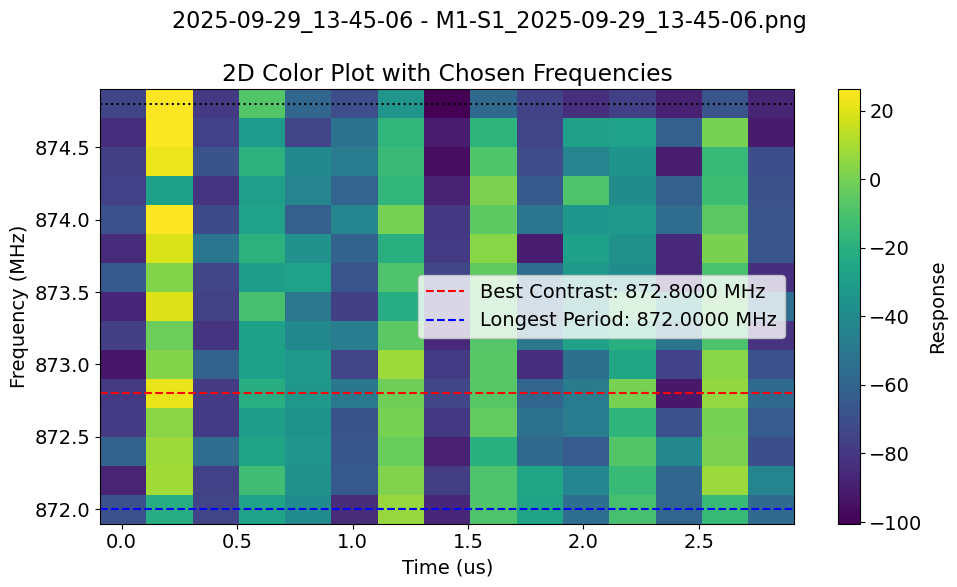

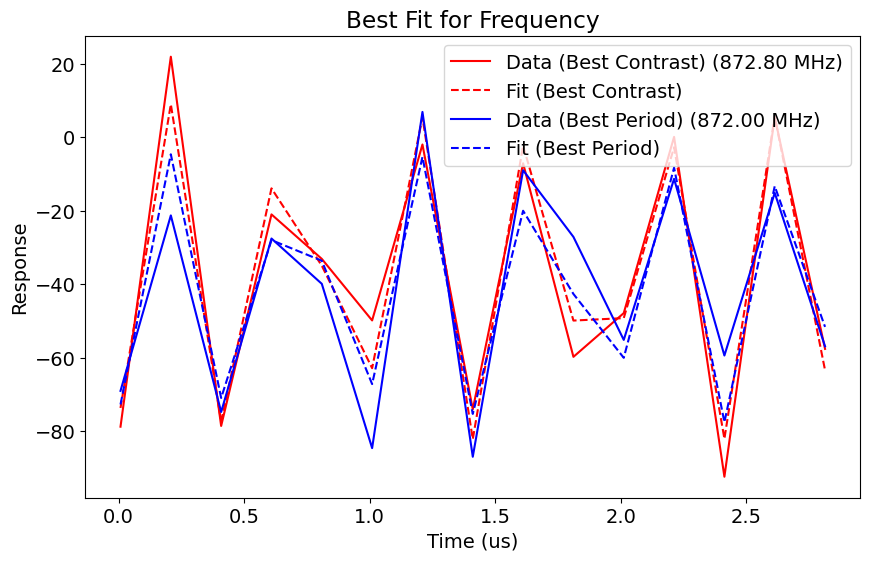

Creating or updating new csv at path: man1_storage_swap_dataset_copy.csv
Updated the frequency to: 872.0000000000003
Creating or updating new csv at path: man1_storage_swap_dataset_copy.csv
Updated the pi length to: 0.24569225357274907
Creating or updating new csv at path: man1_storage_swap_dataset_copy.csv
Updated the h_pi length to: 0.12284612678637453
Running error amplification (gain) for storage mode 1
post pulse [['multiphoton', 'f0-g1', 'pi', 0], ['multiphoton', 'e0-f0', 'pi', 0]]
cfg at start of acquire {'reps': 50, 'qubit': 0, 'qubits': [0], 'active_reset': False, 'man_reset': True, 'storage_reset': True, 'start': 2816, 'expts': 50, 'step': 20, 'n_start': 0, 'n_step': 3, 'n_pulses': 15, 'pulse_type': ['storage', 'M1-S1', 'pi', 0], 'parameter_to_test': 'gain', 'rounds': 1}
n_pts [ 0  3  6  9 12 15]


  0%|          | 0/6 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [36]:
for i, stor_i in enumerate(expts_to_run['stor_modes']):
# for stor_i in [5]:

    stor_name = 'M1-S' + str(stor_i)
    if expts_to_run['sideband_freq_sweep']:

        # ds_thisrun.update_gain(stor_name, 9000)
        # ds_thisrun.update_freq(stor_name, 873.6)
        # ds_thisrun.update_freq(stor_name, 348.66845603890465)
        # ds_thisrun.update_pi(stor_name, abs(ds_thisrun.get_pi(stor_name)))
        # ds_thisrun.update_h_pi(stor_name, abs(ds_thisrun.get_h_pi(stor_name)))

        print(f'Running coarse sideband sweep for storage mode {stor_i}')
        freq_start = ds_thisrun.get_freq(stor_name) - 1.5
        freq_stop = ds_thisrun.get_freq(stor_name) + 1.5
        freq_step = 0.2
        # freq_start = ds_thisrun.get_freq(stor_name) - 0.2
        # freq_stop = ds_thisrun.get_freq(stor_name) + 0.2
        # freq_step = 0.1
        sideband_chevrons_coarse[i] = do_sideband_general_sweep(config_thisrun, ds_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step, reps=50, man_mode_no=1, stor_mode_no=stor_i, liveplotting=False)
        update_sideband_general_sweep(expt_path, config_thisrun, ds_thisrun, man_mode_no=1, stor_mode_no=stor_i)


        print(f'Running error amplification (gain) for storage mode {stor_i}')
        error_amp_exp_gain = do_error_amp_storage(
            config_thisrun, ds_thisrun, expt_path, config_path, reps=50, rounds=1, qubit=0, span=1000, expts=50, n_start=0, n_step=3, n_pulses=15, man_mode_no=1, stor_mode_no=stor_i, stor_is_dump=False, parameter_to_test='gain')
        error_amp_gain1[i] = error_amp_exp_gain
        error_amp_exp_gain.analyze(state_fin='e')
        error_amp_exp_gain.display()
        gain_opt = int(error_amp_exp_gain.data['fit_avgi'][2])
        # Update dataset
        ds_thisrun.update_gain(stor_name, gain_opt)
        print('Updated the gain to:', gain_opt)


        print(f'Running error amplification (frequency) for storage mode {stor_i}')
        error_amp_exp_freq = do_error_amp_storage(
            config_thisrun, ds_thisrun, expt_path, config_path, reps=50, rounds=1, qubit=0, span=0.3, expts=50, n_pulses=10, man_mode_no=1, stor_mode_no=stor_i, stor_is_dump=False, parameter_to_test='frequency')
        error_amp_freq1[i] = error_amp_exp_freq
        error_amp_exp_freq.analyze(state_fin='e')
        error_amp_exp_freq.display()
        freq_opt = error_amp_exp_freq.data['fit_avgi'][2]
        # Update dataset
        ds_thisrun.update_freq(stor_name, freq_opt)
        print('Updated the frequency to:', freq_opt)


        # print(f'Running error amplification (gain) ROUND 2 for storage mode {stor_i}')
        # error_amp_exp_gain2 = do_error_amp_storage(
        #     config_thisrun, ds_thisrun, expt_path, config_path, reps=50, rounds=1, qubit=0, span=600, expts=50, n_start=1, n_step=1, n_pulses=10, man_mode_no=1, stor_mode_no=stor_i, stor_is_dump=False, parameter_to_test='gain')
        # error_amp_gain2[i] = error_amp_exp_gain2
        # error_amp_exp_gain2.analyze(state_fin='e')
        # error_amp_exp_gain2.display()
        # gain_opt = int(error_amp_exp_gain2.data['fit_avgi'][2])
        # # Update dataset
        # ds_thisrun.update_gain(stor_name, gain_opt)
        # print('Updated the gain to:', gain_opt)



In [ ]:
# for i, stor_i in enumerate(expts_to_run['stor_modes']):
#     if stor_i != 4: continue
#     # if stor_i == 5: continue

#     stor_name = 'M1-S' + str(stor_i)
#     print(stor_name)
#     ds.update_gain(stor_name, ds_thisrun.get_gain(stor_name))
#     ds.update_freq(stor_name, ds_thisrun.get_freq(stor_name))
#     ds.update_pi(stor_name, ds_thisrun.get_pi(stor_name))
#     ds.update_h_pi(stor_name, ds_thisrun.get_h_pi(stor_name))

# Qubit characterization

In [ ]:
for i in range(len(expts_to_run['stor_modes'])):
    print('Frequency for M1-S' + str(i+1) + ':', ds_thisrun.get_freq('M1-S' + str(i+1)))

In [ ]:
# #Update sweep data and analyze results

# temp_data, attrs, filename = prev_data(expt_path, prefix='sideband_general_sweep')
# print('File saved at:', filename)

# from multimode_expts.fit_display_classes import ChevronFitting
# from datetime import datetime
# chevron_analysis = ChevronFitting(
#     frequencies=temp_data['freq_sweep'],
#     time=temp_data['xpts'][0],
#     response_matrix=temp_data['avgi'],
#     config = config_thisrun,
# )
# chevron_analysis.analyze()

# current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# chevron_analysis.display_results(save_fig=True,  title=f'M{1}-S{7}_{current_time}')

In [ ]:
# i = 5
# print(f'Running fine sideband sweep for storage mode {i + 1}')
# freq_start = ds_thisrun.get_freq('M1-S' + str(i + 1)) - 1.5
# freq_stop = ds_thisrun.get_freq('M1-S' + str(i + 1)) + 1.5
# freq_step = 0.2
# sideband_chevrons_fine = do_sideband_general_sweep(
#     config_thisrun, ds_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step, 
#     man_mode_no=1, stor_mode_no=i + 1, start_time=0.1, use_flux_low=True)
# # update_sideband_general_sweep(expt_path, config_thisrun, ds_thisrun, man_mode_no=1, stor_mode_no=i + 1, use_flux_low=True)

In [ ]:
# i = 5
# print(f'Running fine sideband sweep for storage mode {i + 1}')
# freq_start = ds_thisrun.get_freq('M1-S' + str(i + 1)) - 0.5
# freq_stop = ds_thisrun.get_freq('M1-S' + str(i + 1)) + 0.5
# freq_step = 0.2
# sideband_chevrons_fine = do_sideband_general_sweep(
#     config_thisrun, ds_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step, 
#     man_mode_no=1, stor_mode_no=i + 1, start_time=0.1, use_flux_low=False)
# # update_sideband_general_sweep(expt_path, config_thisrun, ds_thisrun, man_mode_no=1, stor_mode_no=i + 1, use_flux_low=True)

### Manually get the frequencies from the chevrons

In [ ]:
# file_list = [34,36,38,40,42,44,46]
# chevrons_stor_objects = [None]* len(file_list)
# name = '_sideband_general_sweep.h5'
# # name = '_storage_sideband_sweep.h5'
# for idx, file_no in enumerate(file_list):
#     full_name = str(file_no).zfill(5)+name
#     expt_path_mod = r"H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data"
#     temp_data, attrs, filename = prev_data(expt_path_mod, full_name)  # ef

#     from multimode_expts.fit_display_classes import ChevronFitting
#     chevron_analysis = ChevronFitting(
#         frequencies=temp_data['freq_sweep'],
#         time=temp_data['xpts'][0],
#         response_matrix=temp_data['avgi']
#     )
#     chevrons_stor_objects[idx] = chevron_analysis

In [ ]:
# i = 6
# # guess_freq = 1422.66
# anls = chevrons_stor_objects[i]
# anls.analyze()
# anls.display_results(save_fig=False, 
#                     directory=autocalib_path, 
#                     title=f'M1-S{i+1}')
#                 #  hlines = [guess_freq])
# ds_thisrun.update_freq('M1-S' + str(i+1), anls.results['best_frequency_period'])
# # or override manually 
# # ds_thisrun.update_freq('M1-S' + str(i+1), 1052.8026)

In [ ]:
# ds_thisrun.df

In [ ]:

# ds_thisrun.update_freq('M1-S' + str(i), guess_freq)

In [ ]:
# ds_thisrun.get_freq('M1-S3')

## Sideband General

In [ ]:
def do_sideband_general(config_thisrun, expt_path, config_path, man_mode_no = 1,stor_mode_no=1):
    """Run the Sideband General Experiment."""
    
    sideband_general = meas.single_qubit.sideband_general.SidebandGeneralExperiment(
        soccfg=soc, path=expt_path, prefix='SidebandGeneralExperiment', config_file=config_path
    )

    sideband_general.cfg = AttrDict(deepcopy(config_thisrun))

    # Sideband general experiment parameters
    freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse = get_storage_mode_parameters(ds_thisrun, config_thisrun, man_mode_no, stor_mode_no)

    sideband_general.cfg.expt = dict(
        start=0.007,  # Pulse start length [us]
        step=0.05,  # Pulse step length [us]
        qubits=[0],
        expts=100,
        reps=200,
        rounds=1,
        flux_drive=[ch, freq, gain],  # RF flux modulation
        prepulse=True,
        postpulse=True,
        active_reset=False,
        man_reset=True,
        storage_reset=True,
        update_post_pulse_phase=[False, 1.07],
        pre_sweep_pulse=prepulse,
        post_sweep_pulse=postpulse,
    )

    sideband_general.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
    sideband_general.go(analyze=False, display=False, progress=True, save=True)
    from multimode_expts.fit_display_classes import LengthRabiFitting
    sideband_analysis = LengthRabiFitting(sideband_general.data, config=sideband_general.cfg)
    sideband_analysis.analyze()
    sideband_analysis.display(title_str='Sideband General', save_fig=True)

    return sideband_analysis


def update_sideband_general(sideband_general, config_thisrun, ds, man_mode_no=1, stor_mode_no=1):
    """Update the configuration and dataset based on Sideband General experiment results."""
    # Analyze the data
    

    # Update dataset
    pi_length = sideband_general.results['pi_length']
    pi2_length = sideband_general.results['pi2_length']
    gain = sideband_general.cfg.expt['flux_drive'][2]
    freq = sideband_general.cfg.expt['flux_drive'][1]
    ds.update_all('M' + str(man_mode_no) + '-S' + str(stor_mode_no), freq, np.nan, pi_length, pi2_length, gain)
    print(f'Updated configuration and dataset: pi_length={pi_length}, pi2_length={pi2_length}, gain={gain}')



In [ ]:
len_rabi_storages = [None]* len(expts_to_run['stor_modes'])
if expts_to_run['sideband_length_rabi']:
    for man_mode_no in expts_to_run['man_modes']:
        for stor_mode_no in expts_to_run['stor_modes']:
            print(f'Running sideband general for manipulation mode {man_mode_no} and storage mode {stor_mode_no}')
            len_rabi_storages[stor_mode_no-1] = do_sideband_general(config_thisrun, expt_path, config_path, man_mode_no, stor_mode_no)
            update_sideband_general(len_rabi_storages[stor_mode_no-1], config_thisrun, ds_thisrun, man_mode_no, stor_mode_no)


In [ ]:
# stor_mode_no = 1
# man_mode_no = 1
# len_rabi_storage = do_sideband_general(config_thisrun, expt_path, config_path, man_mode_no, stor_mode_no)
# update_sideband_general(len_rabi_storage, config_thisrun, ds_thisrun, man_mode_no, stor_mode_no)

## Randomized Benchmarking

In [ ]:
len([1, 5, 10, 15, 25, 50, 75, 100, 150, 200, 250, 400, 500, 600, 700, 850, 1000, 1250, 1500])

In [ ]:
# config_thisrun.device.storage.ramp_sigma
# man_mode_no = 1
# stor_mode_no = 7
# req = ds_thisrun.get_freq('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
# gain = ds_thisrun.get_gain('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
# hpi_length = ds_thisrun.get_h_pi('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
# print("ramp_sigma:", config_thisrun.device.storage.ramp_sigma)
# print("man_mode_no:", man_mode_no)
# print("stor_mode_no:", stor_mode_no)
# print("freq:", req)
# print("gain:", gain)
# print("hpi_length:", hpi_length)

In [ ]:

def do_single_beam_splitter_rb_postselection_sweep_depth(config_thisrun, ds_thisrun, expt_path, config_path, exp_param_file, man_mode_no=1, stor_mode_no=1,
                                                         prev_data=None):
    """
    Run the SingleBeamSplitterRBPostSelection_sweep_depth experiment.
    """
    from multimode_expts.sequential_experiment_classes import MM_DualRailRB
    experiment_class = MM_DualRailRB
    sweep_experiment_name = 'SingleBeamSplitterRBPostSelection_sweep_depth'
    class_for_exp = experiment_class(
        soccfg=soc, path=expt_path, prefix=sweep_experiment_name, config_file=config_path, exp_param_file=exp_param_file, 
        prev_data=prev_data
    )

    class_for_exp.yaml_cfg = AttrDict(deepcopy(config_thisrun))
    # Customize bs_para for the given manipulation and storage mode using ds_thisrun directly
    freq = ds_thisrun.get_freq('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
    gain = ds_thisrun.get_gain('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
    hpi_length = ds_thisrun.get_h_pi('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
    bs_para = [freq, gain, hpi_length, config_thisrun.device.storage.ramp_sigma]
    print('Beam splitter parameters:', bs_para)
    # Optionally, set up experiment parameters here if needed, e.g.:
    # class_for_exp.loaded[sweep_experiment_name] = dict(...)
    class_for_exp.loaded[sweep_experiment_name] = dict(
        depth_list=[1, 5, 10, 15, 25, 50, 75, 100, 150, 200, 250, 400, 500, 600, 700, 850, 1000, 1250, 1500, 2000],  # RB sequence depth list
        reps_list = [],
        qubits=[0],
        reps=0,  # doesn't matter

        single_shot_bef_expt=False,  # single shot before experiment
        singleshot_reps=2000,        # single shot measurement repetitions
        span=1000,                   # single shot plot span

        active_reset=False,          # for single shot post selection
        man_reset=True,              # for single shot post selection
        storage_reset=True,          # for single shot post selection
        threshold=None,              # for single shot post selection
        readout_per_round=4,         # for single shot post selection

        rb_active_reset=False,
        rb_man_reset=True,
        rb_storage_reset=True,
        rb_reps=1000,
        gates_per_wait=100000,       # ????
        parity_meas=True,            # If parity measurement is used, set to True; if False the reset arguments below should be false as well
        reset_qubit_after_parity=False,  # True # resetting via second parity str 
        reset_qubit_via_active_reset_after_first_meas=False,  # resetting via active reset after first parity str; the other reset should be false

        rounds=1,                    # always set to 1
        variations=10,                # number of different sequences
        rb_depth=10,                 # rb sequence depth
        IRB_gate_no=-1,              # IRB gate number, -1 means not using
        postselection_delay=2.0,     # in us, gap between two readout pulses
        bs_repeat=1,
        sync=False,
        setup=False,

        bs_para=bs_para,  # at 96  # beam splitter parameters [[frequency], [gain], [length (us)], [sigma]]
        prepulse=False,
        postpulse=False,
        f0g1_offset=0,               # offset phase in deg as a result of f0g1 prepulse/postpulse

        pre_sweep_pulse=[[None]],    # Gate based; prep f0g1 is done automatically ; RAM state prep is also automatic 
        ram_prepulse=[False, 6, [1], 1],  # [True/False, number of storage modes to be populated, [idx of modes to be skipped], variations]
        ram_prepulse_strs=None       # see SingleBeamSplitterRBPostSelection_sweep_depth_and_ram
    )
    

    class_for_exp.yaml_cfg.device.readout.relax_delay = [8000]  # Example, adjust as needed

    prefix, dir_path =eval('class_for_exp.run_sweep')(sweep_experiment_name=sweep_experiment_name)
    print('File saved at:', prefix)
    print('Directory path:', dir_path)

    # from multimode_expts.fit_display_classes import MM_DualRailRBFitting
    # rb_analysis = MM_DualRailRBFitting(
    #     filename=None,
    #     file_prefix=prefix,
    #     config=yaml_cfg,
    #     expt_path=expt_path,
    #     title=f'M{man_mode_no}-S{stor_mode_no}',
    #     prev_data=prev_data,
    #     dir_path=dir_path
    # )
    # rb_analysis.show_rb(save_fig=True)
    # return rb_analysis


In [ ]:
if expts_to_run['RB']:
    storage_rbs = [None] * len(expts_to_run['stor_modes'])
    for i in range(len(expts_to_run['stor_modes'])):
        print(f'Running storage RB postselection sweep depth for storage mode {i + 1}')
        storage_rbs[i] = do_single_beam_splitter_rb_postselection_sweep_depth(
            config_thisrun,
            ds_thisrun,
            expt_path,
            config_path,
            exp_param_file=exp_param_file,
            man_mode_no=1,
            stor_mode_no=i + 1
        )

In [ ]:
# from multimode_expts.fit_display_classes import MM_DualRailRBFitting
# dir_no = np.arange(72, 80, 1 )
# for idx, dir_no in enumerate(dir_no):
#     prefix = f"SingleBeamSplitterRBPostSelection_sweep_depth"
#     dir_name = f"{str(dir_no).zfill(5)}_SingleBeamSplitterRBPostSelection_sweep_depth" 
#     dir_path = r"H:\\\\Shared drives\\\\SLab\\\\Multimode\\\\experiment\\\\250505_craqm\\\\data\\\\" + dir_name
#     filepath = dir_path
#     # Initialize RB analysis
#     rb_analysis = MM_DualRailRBFitting(
#         filename=None,
#         file_prefix=prefix,
#         config=yaml_cfg,
#         expt_path=expt_path,
#         title=f"M1-S{idx + 1} RB Analysis",
#         prev_data=prev_data,
#         dir_path=filepath
#     )
#     rb_analysis.show_rb(save_fig=True)



In [ ]:
dir_no = 78
dir_name = f"{str(dir_no).zfill(5)}_SingleBeamSplitterRBPostSelection_sweep_depth" 
dir_path = r"H:\\\\Shared drives\\\\SLab\\\\Multimode\\\\experiment\\\\250505_craqm\\\\data\\\\" + dir_name
temp_data, attrs, filename = prev_data(dir_path, prefix='SingleBeamSplitterRBPostSelection_sweep_depth')

In [ ]:
atrrs = AttrDict(attrs)
attrs['config']['device']['qubit']['f_ge']

In [ ]:
# storage_rb

In [ ]:
expt_test = Experiment(
            path=expt_path,
            prefix="yoyoyo",
            config_file=config_path,
        )

In [ ]:
expt_test.data = {}
f = expt_test.save_data()

In [ ]:
if expts_to_run['RB']:
    filename = expt_test.fname
    #create a directory with the filename but no .h5 extension
    import os
    directory = filename
    if directory.lower().endswith('.h5'):
        directory = directory[:-3]
    if not os.path.exists(directory):
        # Only create the directory if it is not the same as the filename (i.e., filename is not a directory itself)
        # Make sure the directory name does not have a .h5 extension
        os.makedirs(directory)

In [ ]:
# directory
# filename_only = os.path.basename(expt_test.fname)
# filename_only

In [ ]:
if expts_to_run['RB']:
    from multimode_expts.fit_display_classes import MM_DualRailRBFitting
    rb_analysis = MM_DualRailRBFitting(file_prefix = "SingleBeamSplitterRBPostSelection_sweep_depth", 
                                    config=config_thisrun, expt_path=expt_path, title='M1_S1', 
                                    prev_data= prev_data)
    rb_analysis.show_rb()

In [ ]:
if expts_to_run['RB']:
    temp_data, attrs, filename = prev_data(expt_path, '00036_SingleBeamSplitterRBPostSelection_sweep_depth.h5')

In [ ]:
attrs['config'].keys()

In [ ]:
temp_data.keys()

In [ ]:
num_entries = len(temp_data['Idata'])
print(f"Number of entries in 'Idata': {num_entries}")

In [ ]:
temp_data['sequences']

# Shock TLS Function

In [ ]:
from multimode_expts.experiments.single_qubit.pulse_probe_f0g1_spectroscopy import PulseProbeF0g1SpectroscopyExperiment

def do_pulse_probe_f0g1_spectroscopy(config_thisrun, expt_path, config_path, 
                                     start=2007, step=0.02, expts=300, reps=100,
                                       rounds=1, length=1, gain=5000, pulse_type='gaussian',
                                         qubit_f=True, qubits=[0], prepulse=False, pre_sweep_pulse=None):
    """
    Run the PulseProbeF0g1SpectroscopyExperiment with specified parameters.
    """
    
    expt = PulseProbeF0g1SpectroscopyExperiment(
        soccfg=soc, path=expt_path, prefix='PulseProbeF0g1SpectroscopyExperiment', config_file=config_path
    )
    expt.cfg = AttrDict(deepcopy(config_thisrun))
    expt.cfg.expt = dict(
        start=start,
        step=step,
        expts=expts,
        reps=reps,
        rounds=rounds,
        length=length,
        gain=gain,
        pulse_type=pulse_type,
        qubit_f=qubit_f,
        qubits=qubits,
        prepulse=prepulse,
        pre_sweep_pulse=pre_sweep_pulse
    )
    expt.cfg.device.readout.relax_delay = [5]  # Wait time between experiments [us]
    expt.go(analyze=True, display=True, progress=True, save=True)
    return expt

In [ ]:
# t2ramsey_ge_check = None
# while True: 
#     #close previous plots 
#     # import matplotlib.pyplot as plt
#     #each iteration is 5 minutes
#     # do_pulse_probe_f0g1_spectroscopy(
#     #     config_thisrun, expt_path, config_path,
#     #     start=3300, step=0.04, expts=10000, reps=100,
#     #     rounds=5, length=50, gain=30000, pulse_type='gaussian',
#     #     qubit_f=False, qubits=[0], prepulse=False, pre_sweep_pulse=None
#     # )

#     do_pulse_probe_ge(config_thisrun, start = 3300, 
#                       step = 0.04, expts = 10000, reps = 100, rounds = 5,
#                       length = 50, gain = 30000)
#     from IPython.display import clear_output
#     # from multimode_expts.fit_display_classes import SidebandFitting
#     clear_output(wait=True)
#     plt.close('all')  # Close all existing figures
#     t2ramsey_ge_check = do_t2_ramsey_ge(config_thisrun, expt_path, config_path)
#     t2ramsey_ge_check.analyze()
#     t2ramsey_ge_check.display(title_str='T2_ge_TLS')


In [ ]:
from multimode_expts.MM_base import MMAveragerProgram
from multimode_expts.experiments.qsim.utils import ensure_list_in_cfg

class ShockTLSProgram(MMAveragerProgram):
    def initialize(self):
        self.MM_base_initialize()
        
        
    def body(self):
        self.reset_and_sync()

        self.setup_and_pulse(
            ch=0,
            style='const',
            freq=self.freq2reg(1918, gen_ch=0),
            length=50,
            phase=0,
            gain=30000,
        )
    def update(self):
        print('Updating frequency...')
        print('Current frequency (MHz):', self.reg2freq(self.r_freq2, gen_ch=0))
        print('Frequency step (MHz):', self.f_step)
        self.mathi(self.q_rp, self.r_freq2, self.r_freq2, '+', self.f_step) # update frequency list index


class ShockTLSExperiment(Experiment):
    def acquire(self, progress):
        ensure_list_in_cfg(self.cfg)
        
        self.prog = ShockTLSProgram(soccfg=self.soccfg, cfg=self.cfg)
        self.prog.acquire(self.im[self.cfg.aliases.soc],
                         threshold=None,
                         load_pulses=True,
                         progress=progress,
                         debug=False)
    

### ShockTLS !!!

In [ ]:
shockTLS_bool = False # Set to FALSE to avoid running!!!!!!
if shockTLS_bool:    
    scktls = ShockTLSExperiment(soccfg=soc, path=expt_path, prefix='shockTLS',
                            config_file=config_path)
    scktls.cfg = AttrDict(deepcopy(config_thisrun))

    scktls.cfg.expt = dict(expts=2000, reps=2000, rounds=100000, qubit=[0])

    scktls.cfg.device.readout.relax_delay = [50] # Wait time between experiments [us]
    for kk in range(50):
        scktls.go(analyze=False, display=False, progress=True, save=False)

# Update Config and Dataset

In [36]:
def convert_attrdict_to_dict(attrdict):
    """
    Recursively converts an AttrDict or a nested dictionary into a standard Python dictionary.
    Converts np.float64 values to standard Python float.

    Args:
        attrdict (AttrDict or dict): The input AttrDict or dictionary to be converted.

    Returns:
        dict: A standard Python dictionary with all nested AttrDicts or dictionaries converted.
    """
    if isinstance(attrdict, AttrDict):
        return {key: convert_attrdict_to_dict(value) for key, value in attrdict.items()}
    elif isinstance(attrdict, dict):
        return {key: convert_attrdict_to_dict(value) for key, value in attrdict.items()}
    elif isinstance(attrdict, np.float64):
        return float(attrdict)
    else:
        return attrdict


def convert_numbers_to_float(data):
    """
    Recursively converts all numbers in a dictionary to float.

    Args:
        data (dict): The input dictionary.

    Returns:
        dict: A dictionary with all numbers converted to float.
    """
    if isinstance(data, dict):
        return {key: convert_numbers_to_float(value) for key, value in data.items()}
    elif isinstance(data, list):
        return [convert_numbers_to_float(item) for item in data]
    elif isinstance(data, float):
        return float(data)
    elif isinstance(data, int):
        return int(data)
    else:
        return data

## Dataset comparison for man1_storage_swap_dataset

In [30]:
#compare the two datsets
differences = ds_thisrun.compare_with(ds)
# Filter out differences related to 'last_update' column
filtered_differences = [diff for diff in differences if diff['column'] != 'last_update']
# Update labels and calculate differences
for diff in filtered_differences:
    if np.isnan(diff['self_value']) and np.isnan(diff['other_value']):
        diff['difference'] = None
        continue
    diff['label'] = f"New value: {diff['self_value']}, Old value: {diff['other_value']}"
    diff['difference'] = diff['self_value'] - diff['other_value'] if isinstance(diff['self_value'], (int, float)) and isinstance(diff['other_value'], (int, float)) else None

# Group differences by storage name
grouped_differences = {}
for diff in filtered_differences:
    stor_name = diff['stor_name']
    if stor_name not in grouped_differences:
        grouped_differences[stor_name] = []
    grouped_differences[stor_name].append(diff)

# Print grouped differences
for stor_name, diffs in grouped_differences.items():
    print(f"In {stor_name}:")
    for diff in diffs:
        if np.isnan(diff['self_value']) and np.isnan(diff['other_value']):
            continue
        print(f"  Column '{diff['column']}': new_value = {diff['self_value']}, old_value = {diff['other_value']}, difference = {diff['difference']}")
    grouped_differences[stor_name].append(diff)


In M1-S1:
In M1-S2:
In M1-S3:
In M1-S4:
In M1-S5:
In M1-S6:
In M1-S7:
In M1:


In [31]:
ds_thisrun.df["gain (DAC units)"] = ds_thisrun.df["gain (DAC units)"].astype(int)

In [32]:
ds_thisrun.df

,stor_name,freq (MHz),precision (MHz),pi (mus),h_pi (mus),gain (DAC units),last_update
0,M1-S1,348.705722,NaN,1.209192,0.604596,2977,2025-08-18 17:09:22.472298
1,M1-S2,520.119712,NaN,1.157138,0.578569,4765,2025-08-18 17:09:22.478282
2,M1-S3,695.791320,NaN,1.057229,0.528615,4883,2025-08-18 17:09:22.486261
3,M1-S4,873.467193,NaN,1.002202,0.501101,9080,2025-08-18 17:17:21.751136
4,M1-S5,1052.583825,NaN,1.838050,0.919025,7115,2025-08-18 17:09:22.493242
5,M1-S6,1244.545889,NaN,1.359600,0.679800,13375,2025-08-18 17:09:22.500224
6,M1-S7,1422.176794,NaN,2.416182,1.208091,9522,2025-08-18 17:09:22.507236
7,M1-S8,-1.000000,-1.00,-1.000000,-1.000000,-1,51:31.3
8,M1-S9,-1.000000,-1.00,-1.000000,-1.000000,-1,51:31.3
9,M1-S10,-1.000000,-1.00,-1.000000,-1.000000,-1,51:31.3


### set TRUE to update dataset for man1_storage_swap_dataset

In [33]:
# stor new datset at old file path
updateDataset = True # Set to FALSE after this run!!!!!!
if updateDataset:
    # store old dataset  into autocalib_path with date-time in the name
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    old_dataset_path = os.path.join(autocalib_path, f'old_dataset_{current_time}.h5')
    ds_thisrun.save_to_file(old_dataset_path)
    print('Old dataset saved to:', old_dataset_path)

    # save new dataset to current_dataset path
    ds_thisrun.save_to_file(ds.filename)
    # ds = copy(ds_thisrun)
    print('New dataset saved to old file path!')

Creating or updating new csv at path: H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\autocalibration_plots_2025-09-29\old_dataset_2025-09-29_11-51-05.h5
Old dataset saved to: H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\autocalibration_plots_2025-09-29\old_dataset_2025-09-29_11-51-05.h5
Creating or updating new csv at path: C:\_Lib\python\multimode_expts\man1_storage_swap_dataset.csv
New dataset saved to old file path!


## Config comparison for hardware_config_202505

In [49]:
from pprint import pprint
print("Comparing configurations:")

def recursive_compare(d1, d2, path=""):
    for key in d1.keys():
        current_path = f"{path}.{key}" if path else key
        if key not in d2:
            print(f"Key '{current_path}' is missing in config2.")
        elif isinstance(d1[key], dict) and isinstance(d2[key], dict):
            recursive_compare(d1[key], d2[key], current_path)
        elif d1[key] != d2[key]:
            print(f"Key '{current_path}' differs:")
            if isinstance(d1[key], list) and len(d1[key]) == 1:
                print(f"  Old value (config1): {d1[key][0]}")
                print(f"  New value (config2): {d2[key][0]}")
            else:
                print(f"  Old value (config1): {d1[key]}")
                print(f"  New value (config2): {d2[key]}")
    for key in d2.keys():
        current_path = f"{path}.{key}" if path else key
        if key not in d1:
            print(f"Key '{current_path}' is missing in config1.")

recursive_compare(yaml_cfg, config_thisrun)

Comparing configurations:
Key 'device.qubit.f_ge' differs:
  Old value (config1): 3569.6978631006828
  New value (config2): 3569.7028312412162
Key 'device.readout.phase' differs:
  Old value (config1): -257.2228709551043
  New value (config2): -256.74957872415234
Key 'device.readout.threshold' differs:
  Old value (config1): -51.970246701446825
  New value (config2): -48.909669965605076
Key 'device.readout.threshold_list' differs:
  Old value (config1): [-51.970246701446825]
  New value (config2): [-48.909669965605076]
Key 'device.readout.Ie' differs:
  Old value (config1): 5.983001867662411
  New value (config2): 11.013003771407295
Key 'device.readout.Ig' differs:
  Old value (config1): -105.21606798470376
  New value (config2): -105.37786551851556
Key 'device.readout.confusion_matrix_with_active_reset' differs:
  Old value (config1): [0.9557350565428109, 0.04426494345718912, 0.04819277108433736, 0.9518072289156626]
  New value (config2): [0.9669091762497066, 0.033090823750293374, 0.0

In [50]:
# Copy contents from config_thisrun to yaml_cfg except for the storage_man_file
def update_yaml_config(yaml_cfg, config_thisrun):
    """
    Update the yaml_cfg with values from config_thisrun, excluding the storage_man_file.
    """
    updated_config = deepcopy(config_thisrun)
    updated_config.device.storage.storage_man_file = yaml_cfg.device.storage.storage_man_file
    return updated_config

def save_configurations(yaml_cfg, config_thisrun, autocalib_path, config_path):
    """
    Save the old and updated configurations to their respective files.
    """
    # Save old configuration
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    old_config_path = os.path.join(autocalib_path, f'old_config_{current_time}.yaml')
    old_config = convert_numbers_to_float(convert_attrdict_to_dict(yaml_cfg) )
    with open(old_config_path, 'w') as cfg_file:
        yaml.dump(old_config, cfg_file, default_flow_style=False, indent=4, width=80, canonical=False,
                  explicit_start=True, explicit_end=False, sort_keys=False, line_break=True)

    # Save updated configuration
    updated_config = convert_numbers_to_float(convert_attrdict_to_dict(update_yaml_config(yaml_cfg, config_thisrun)))
    with open(config_path, 'w') as f:
        yaml.dump(updated_config, f, default_flow_style=False, indent=4, width=80, canonical=False,
                  explicit_start=True, explicit_end=False, sort_keys=False, line_break=True)

### set TRUE to update hardware_config!!

In [51]:
# Main logic
updateConfig_bool = True # Set to FALSE after this run!!!!!!
updated_config = update_yaml_config(yaml_cfg, config_thisrun)
if updateConfig_bool:
    save_configurations(yaml_cfg, updated_config, autocalib_path, config_path)
    yaml_cfg = updated_config
    updateConfig_bool = False
    print("Configuration updated and saved, excluding storage_man_file. \n!!!!Please set updateConfig to False after this run!!!!!!.")

Configuration updated and saved, excluding storage_man_file. 
!!!!Please set updateConfig to False after this run!!!!!!.

# Loopbackprogram

In [ ]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1)
        
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
        phase = self.deg2reg(cfg["res_phase"], gen_ch=res_ch)
        gain = cfg["pulse_gain"]
        self.default_pulse_registers(ch=res_ch, freq=freq, phase=phase, gain=gain)

        style=self.cfg["pulse_style"]

        if style in ["flat_top","arb"]:
            sigma = cfg["sigma"]
            self.add_gauss(ch=res_ch, name="measure", sigma=sigma, length=sigma*5)
            
        if style == "const":
            self.set_pulse_registers(ch=res_ch, style=style, length=cfg["length"])
        elif style == "flat_top":
            # The first half of the waveform ramps up the pulse, the second half ramps down the pulse
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure", length=cfg["length"])
        elif style == "arb":
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure")
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        # fire the pulse
        # trigger all declared ADCs
        # pulse PMOD0_0 for a scope trigger
        # pause the tProc until readout is done
        # increment the time counter to give some time before the next measurement
        # (the syncdelay also lets the tProc get back ahead of the clock)
        self.measure(pulse_ch=self.cfg["res_ch"], 
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.cfg["adc_trig_offset"],
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))

In [ ]:
GEN_CH = 5
RO_CH = 0
config={"res_ch":GEN_CH, # --Fixed
        "ro_chs":[RO_CH], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "const", # --Fixed
        
        "length":20, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":100, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":3000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 750, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages

       }

###################
# Try it yourself !
###################

prog =LoopbackProgram(soc, config)
iq_list = prog.acquire_decimated( soc = im[config_thisrun.aliases.soc], progress=True)

In [ ]:
iq_list

In [ ]:
# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend();